In [ ]:
# !conda install numpy pandas matplotlib seaborn scikit-learn missingno category_encoders xgboost -y

In [1]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import missingno as msno

from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split

from sklearn.experimental import enable_iterative_imputer 
from sklearn.impute import IterativeImputer
import category_encoders as ce

from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.metrics import roc_auc_score, classification_report, roc_curve, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import cross_val_predict, cross_val_score, StratifiedKFold, GridSearchCV
from sklearn.feature_selection import SelectFromModel

import joblib

In [2]:
data = pd.read_csv('../data/raw/train.data/train.data', sep = '\t')

In [3]:
data['is_churn'] = pd.read_csv('../data/raw/train_churn.labels.txt', header = None)

# for readability and consitency, lets make labels 0 and 1
data['is_churn'] = data.is_churn.apply(lambda x: 0 if (x == -1) else x) 

### EDA

In [4]:
data.shape

(50000, 231)

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Columns: 231 entries, Var1 to is_churn
dtypes: float64(191), int64(2), object(38)
memory usage: 88.1+ MB


In [6]:
data.tail(5)

Var1  Var2  Var3  Var4  Var5    Var6  Var7  Var8  Var9  Var10  ...  \
49995   NaN   NaN   NaN   NaN   NaN   357.0   0.0   NaN   NaN    NaN  ...   
49996   NaN   NaN   NaN   NaN   NaN  1078.0   0.0   NaN   NaN    NaN  ...   
49997   NaN   NaN   NaN   NaN   NaN  2807.0   7.0   NaN   NaN    NaN  ...   
49998   NaN   NaN   NaN   0.0   NaN     NaN   NaN   NaN   NaN    NaN  ...   
49999   NaN   NaN   NaN   NaN   NaN  1694.0   7.0   NaN   NaN    NaN  ...   

        Var222      Var223  Var224  Var225  Var226  Var227  \
49995  EROH7Cg  LM8l689qOp     NaN     NaN    7FJQ    RAYp   
49996  GfSQowC  LM8l689qOp     NaN    kG3k    FSa2    RAYp   
49997  dh6qI2t  LM8l689qOp     NaN    ELof    fKCe    RAYp   
49998  2fF2Oqu  LM8l689qOp     NaN     NaN    FSa2    RAYp   
49999  IIvC99a  LM8l689qOp     NaN     NaN    xb3V    RAYp   

                    Var228  Var229  Var230  is_churn  
49995        F2FyR07IdsN7I     NaN     NaN         0  
49996              55YFVY9    am7c     NaN         0  
49997  TCU50_Yjmm6GIBZ0lL_     NaN     NaN         0  
49998        F2FyR07IdsN7I     NaN     NaN         0  
49999        F2FyR07IdsN7I     NaN     NaN         0  

[5 rows x 231 columns]

In [7]:
data['is_churn'].value_counts()

is_churn
0    46328
1     3672
Name: count, dtype: int64

this an imbalanced dataset as expected.

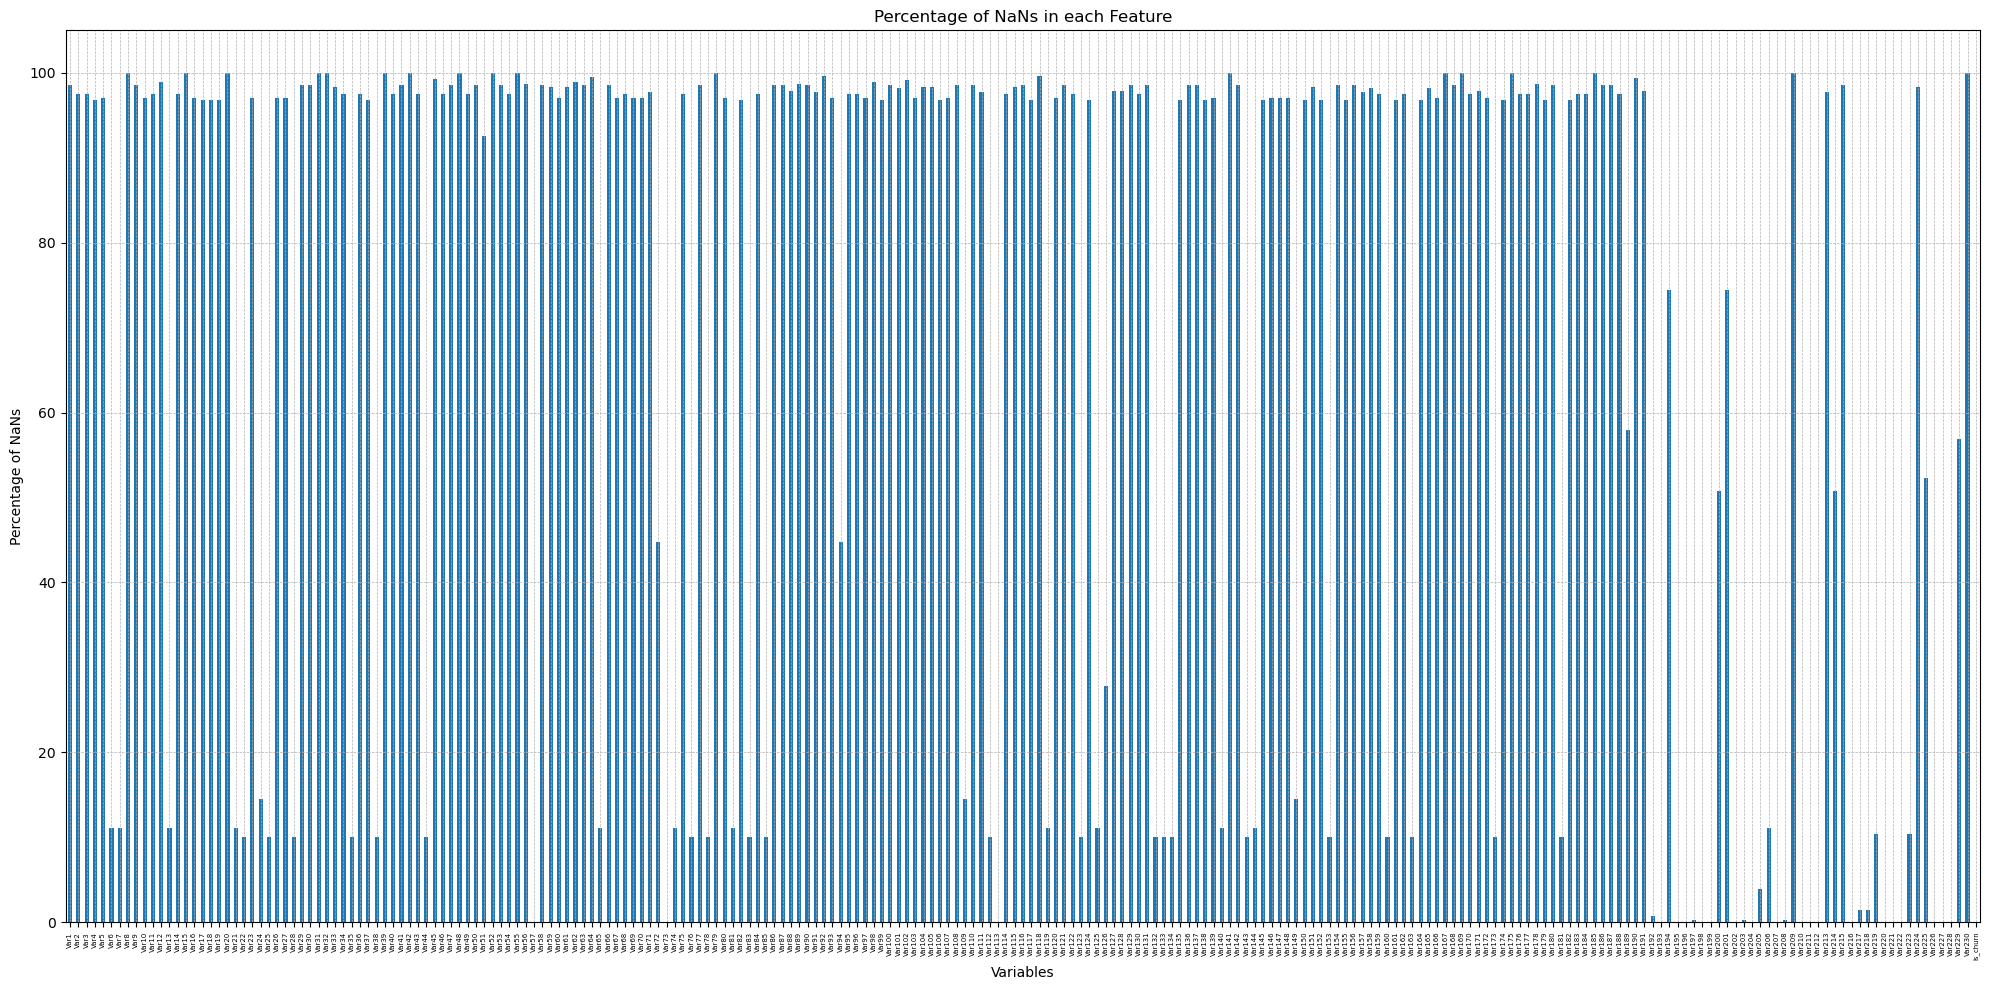

In [8]:
plt.figure(figsize = (20, 10))
(data.isna().sum()/len(data)*100).plot(kind='bar')
plt.xlabel('Variables')
plt.ylabel('Percentage of NaNs')
plt.title('Percentage of NaNs in each Feature')
plt.xticks(rotation=90)  # Rotate labels to vertical
plt.tick_params(axis='x', which='major', labelsize=5)  # Adjust font size
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()  # Adjust layout to make room for label rotation
plt.show()

There seem to be a lot of missing values ,that needs to be carefully dealt with.We may have to check for pattern in the missingness before dealing with nan values(MCAR,MNAR,MAR).

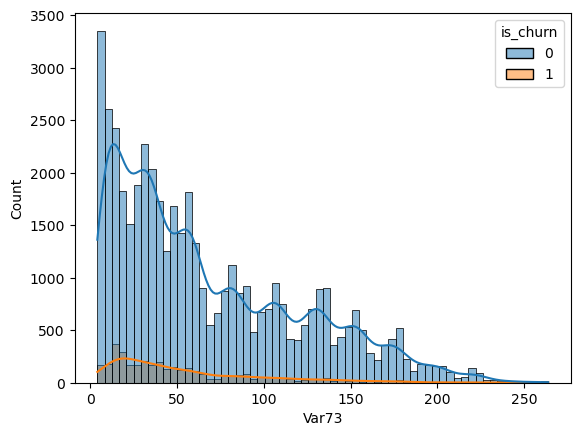

In [9]:
sns.histplot(data=data, x='Var73', hue='is_churn', kde=True)
plt.show()

This seems like a multimodal distribution with oridnality,It may be helpful to bin this.

In [10]:
with pd.option_context('display.max_rows', None):
    display(data.select_dtypes('float').describe().transpose())

count          mean           std           min           25%  \
Var1      702.0  1.148718e+01  4.070995e+01  0.000000e+00  0.000000e+00   
Var2     1241.0  4.029009e-03  1.419332e-01  0.000000e+00  0.000000e+00   
Var3     1240.0  4.252984e+02  4.270194e+03  0.000000e+00  0.000000e+00   
Var4     1579.0  1.253958e-01  1.275481e+00  0.000000e+00  0.000000e+00   
Var5     1487.0  2.387933e+05  6.441259e+05  0.000000e+00  0.000000e+00   
Var6    44471.0  1.326437e+03  2.685694e+03  0.000000e+00  5.180000e+02   
Var7    44461.0  6.809496e+00  6.326053e+00  0.000000e+00  0.000000e+00   
Var8        0.0           NaN           NaN           NaN           NaN   
Var9      702.0  4.814530e+01  1.547779e+02  0.000000e+00  4.000000e+00   
Var10    1487.0  3.926057e+05  9.280896e+05  0.000000e+00  0.000000e+00   
Var11    1240.0  8.625806e+00  2.869558e+00  8.000000e+00  8.000000e+00   
Var12     558.0  1.607168e+01  6.418551e+01  0.000000e+00  0.000000e+00   
Var13   44461.0  1.249688e+03  2.794955e+03  0.000000e+00  0.000000e+00   
Var14    1240.0  7.419355e-01  3.714316e+00  0.000000e+00  0.000000e+00   
Var15       0.0           NaN           NaN           NaN           NaN   
Var16    1487.0  1.202393e+02  7.238625e+01  0.000000e+00  5.192000e+01   
Var17    1579.0  1.139329e+01  4.949386e+01  0.000000e+00  0.000000e+00   
Var18    1579.0  7.215959e+00  3.441543e+01  0.000000e+00  0.000000e+00   
Var19    1579.0  2.450918e-01  1.781497e+00  0.000000e+00  0.000000e+00   
Var20       0.0           NaN           NaN           NaN           NaN   
Var21   44471.0  2.345182e+02  5.655601e+02  0.000000e+00  1.120000e+02   
Var22   44991.0  2.902454e+02  7.044900e+02  0.000000e+00  1.350000e+02   
Var23    1487.0  7.535306e+00  4.944947e+01  0.000000e+00  0.000000e+00   
Var24   42770.0  4.507926e+00  9.928819e+00  0.000000e+00  0.000000e+00   
Var25   44991.0  9.682701e+01  2.143183e+02  0.000000e+00  1.600000e+01   
Var26    1487.0  7.061197e-02  5.288359e-01  0.000000e+00  0.000000e+00   
Var27    1487.0  2.824479e-02  2.472102e-01  0.000000e+00  0.000000e+00   
Var28   44989.0  2.245077e+02  9.852024e+01 -6.688000e+01  1.665600e+02   
Var29     702.0  2.279202e-02  2.124355e-01  0.000000e+00  0.000000e+00   
Var30     702.0  7.435897e+00  8.852461e+00  0.000000e+00  0.000000e+00   
Var31       0.0           NaN           NaN           NaN           NaN   
Var32       0.0           NaN           NaN           NaN           NaN   
Var33     847.0  1.270050e+05  4.957921e+05  0.000000e+00  0.000000e+00   
Var34    1241.0  1.173247e+00  4.377707e+00  0.000000e+00  0.000000e+00   
Var35   44991.0  7.168100e-01  2.996007e+00  0.000000e+00  0.000000e+00   
Var36    1241.0  1.595539e+05  3.277151e+05  0.000000e+00  0.000000e+00   
Var37    1579.0  6.485221e+05  1.382225e+06  0.000000e+00  0.000000e+00   
Var38   44991.0  2.579107e+06  3.010076e+06  0.000000e+00  7.794000e+03   
Var39       0.0           NaN           NaN           NaN           NaN   
Var40    1241.0  1.396293e+01  8.141001e+01  0.000000e+00  0.000000e+00   
Var41     702.0  2.665385e+01  6.184552e+01  0.000000e+00  0.000000e+00   
Var42       0.0           NaN           NaN           NaN           NaN   
Var43    1241.0  4.157937e+00  2.057040e+01  0.000000e+00  0.000000e+00   
Var44   44991.0  1.668334e-01  1.629344e+00  0.000000e+00  0.000000e+00   
Var45     344.0  7.256128e+03  8.798177e+03  0.000000e+00  1.253705e+03   
Var46    1241.0  1.679613e+01  7.081733e+01  0.000000e+00  0.000000e+00   
Var47     702.0  2.188034e+00  1.019071e+01  0.000000e+00  0.000000e+00   
Var48       0.0           NaN           NaN           NaN           NaN   
Var49    1241.0  9.186140e-02  8.805826e-01  0.000000e+00  0.000000e+00   
Var50     702.0  3.569088e+01  1.270346e+02  0.000000e+00  0.000000e+00   
Var51    3747.0  4.365201e+04  7.122949e+04  0.000000e+00  2.982960e+03   
Var52       0.0           NaN           NaN           NaN           NaN   
Var53     702.0  6.543265e+05  1.37

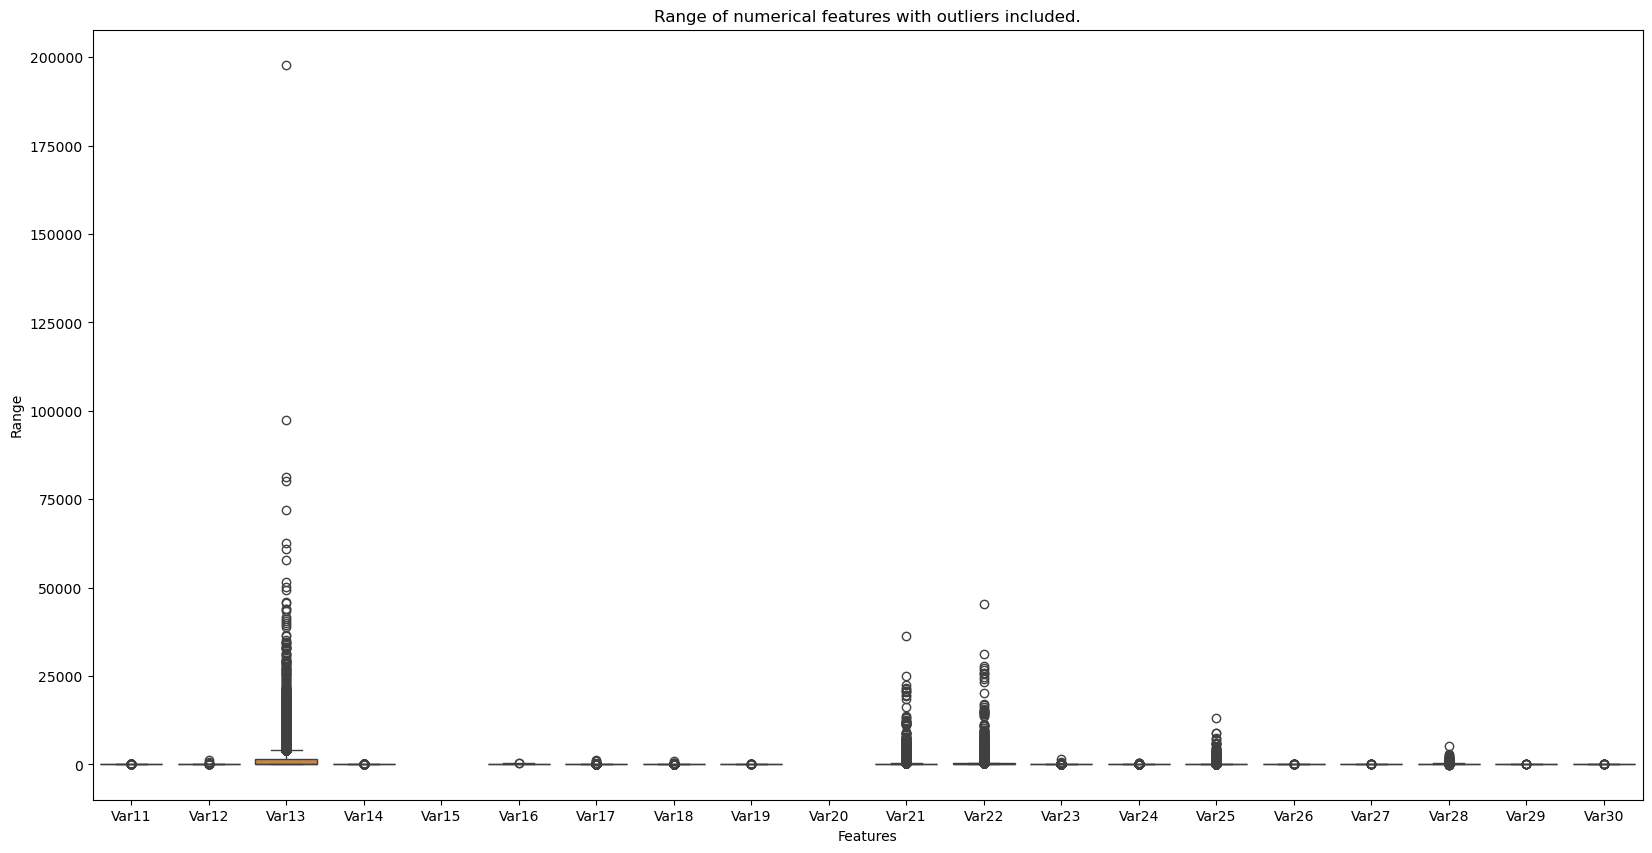

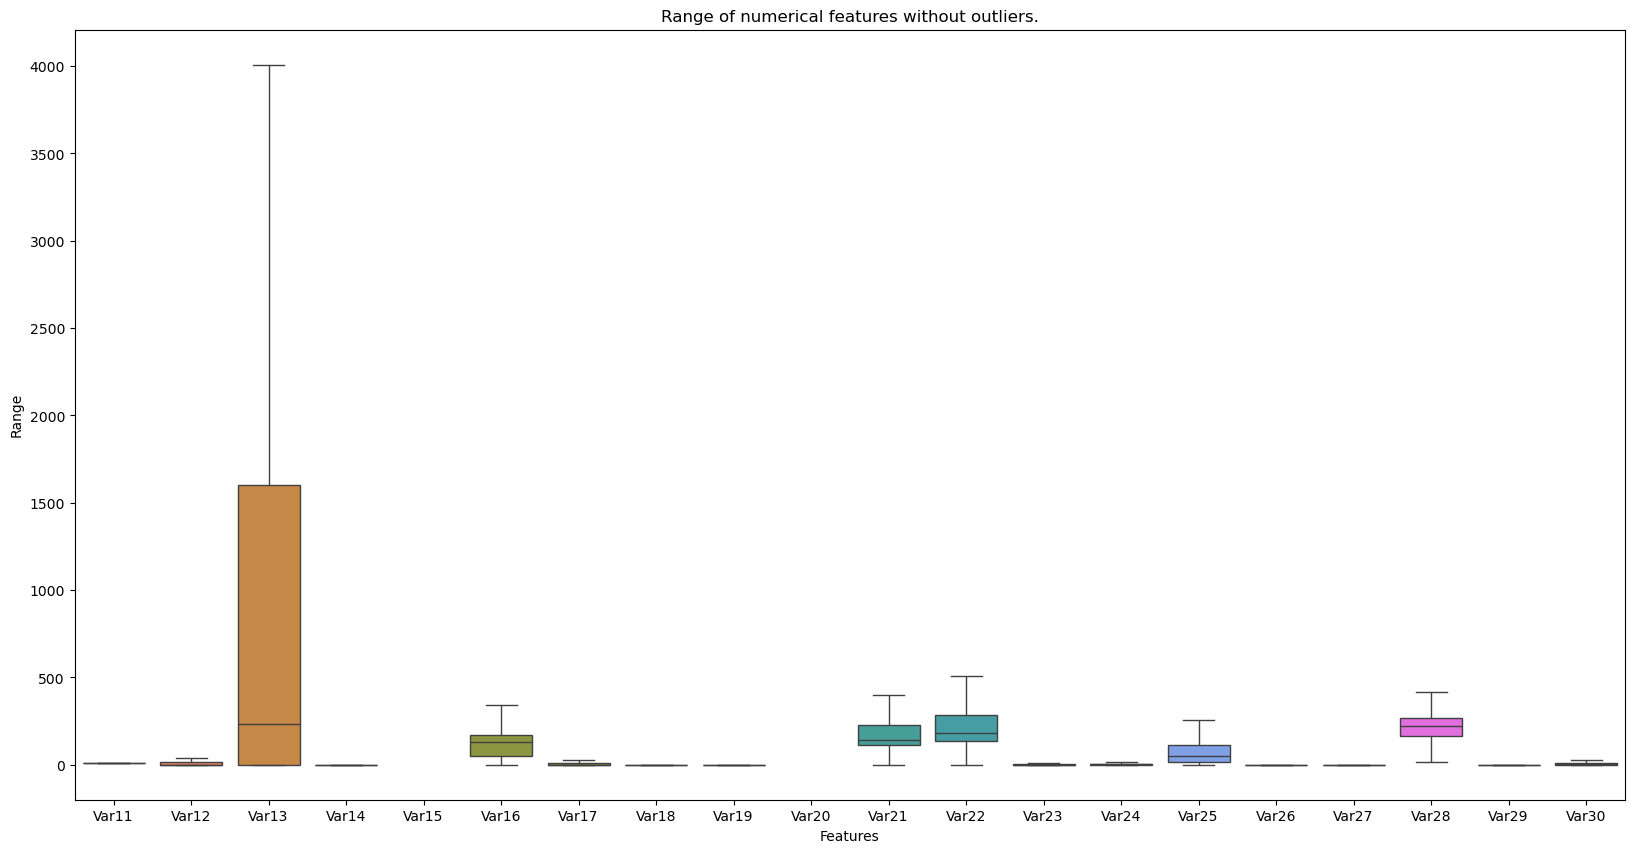

In [11]:
fig = plt.figure(figsize = (20, 10))
sns.boxplot(data = data.iloc[:,10:30])
plt.title('Range of numerical features with outliers included.')
plt.xlabel('Features')
plt.ylabel('Range')
plt.show()
fig = plt.figure(figsize = (20, 10))
sns.boxplot(data = data.iloc[:,10:30],showfliers = False)
plt.title('Range of numerical features without outliers.')
plt.xlabel('Features')
plt.ylabel('Range')
plt.show()

the above table and graph suggest that there may be outliers in data of outliers

In [12]:
data.select_dtypes(include=['O']).nunique().sort_values()

Var191        1
Var224        1
Var215        1
Var213        1
Var218        2
Var211        2
Var208        2
Var201        2
Var225        3
Var194        3
Var205        3
Var223        4
Var229        4
Var196        4
Var203        5
Var210        6
Var227        7
Var221        7
Var207       14
Var206       21
Var219       22
Var226       23
Var195       23
Var228       30
Var193       51
Var212       81
Var204      100
Var197      225
Var192      361
Var216     2016
Var220     4291
Var222     4291
Var198     4291
Var199     5073
Var202     5713
Var217    13990
Var214    15415
Var200    15415
dtype: int64

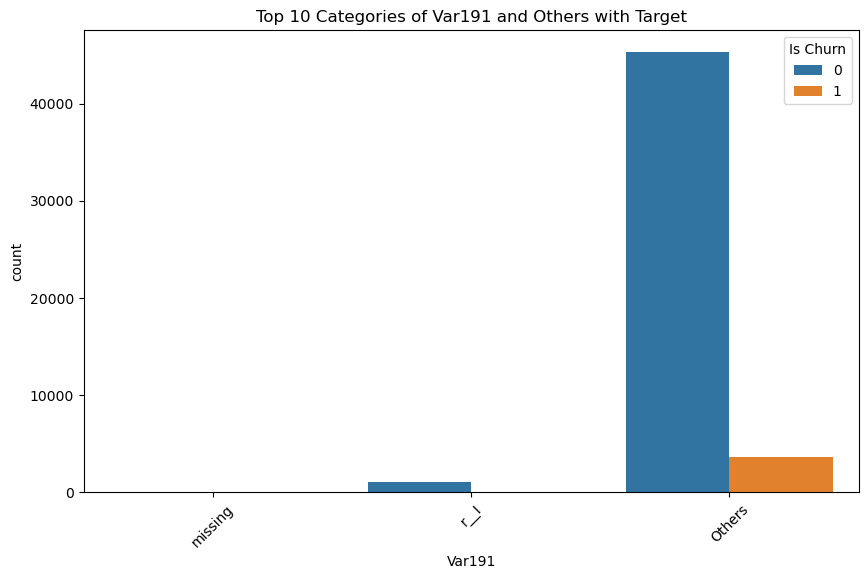

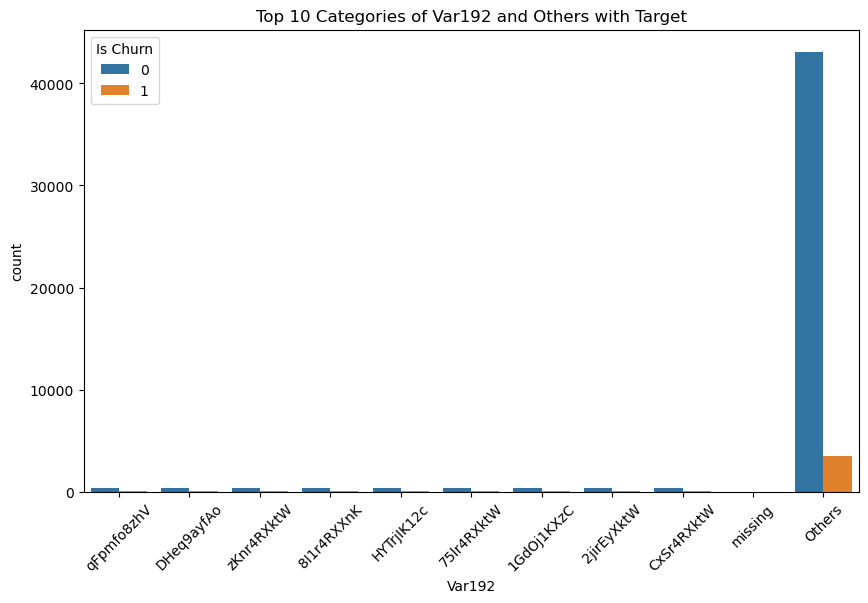

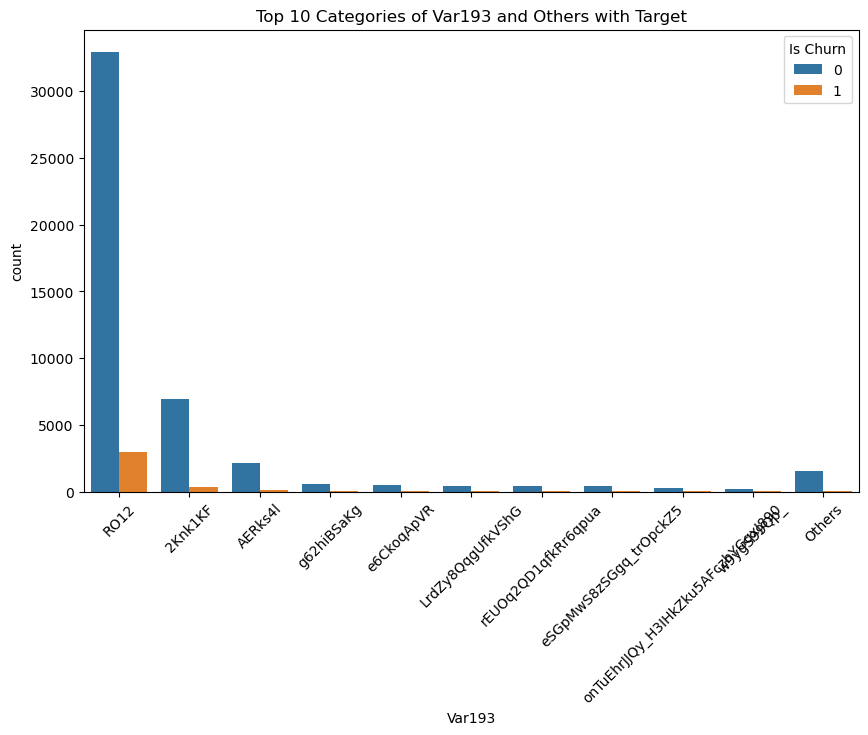

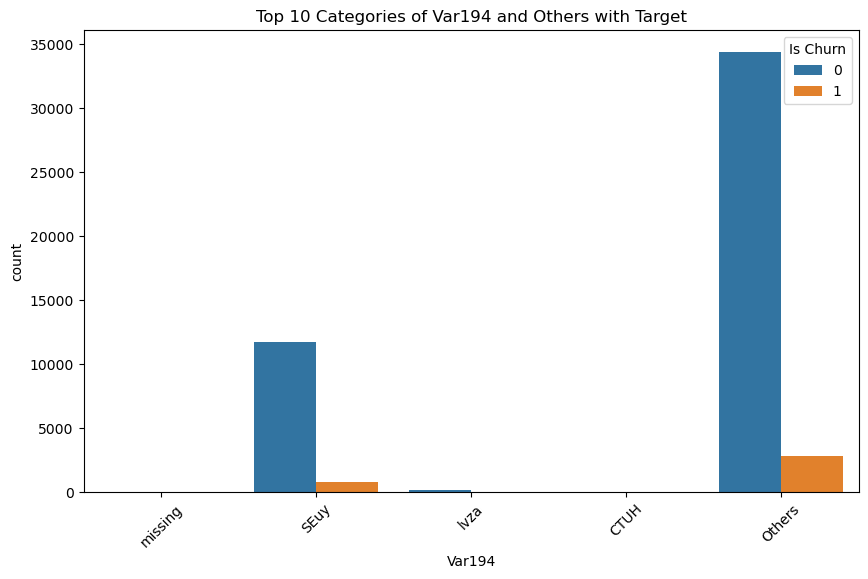

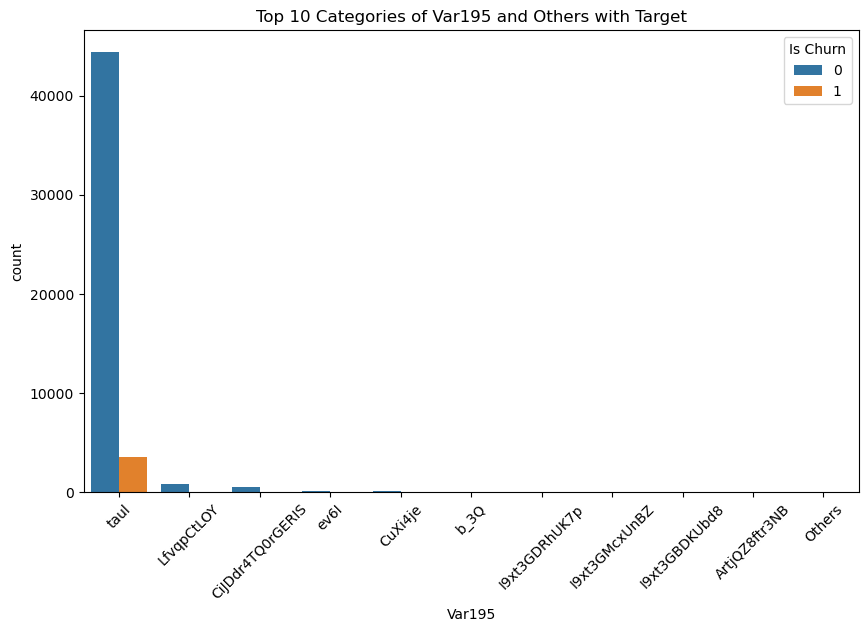

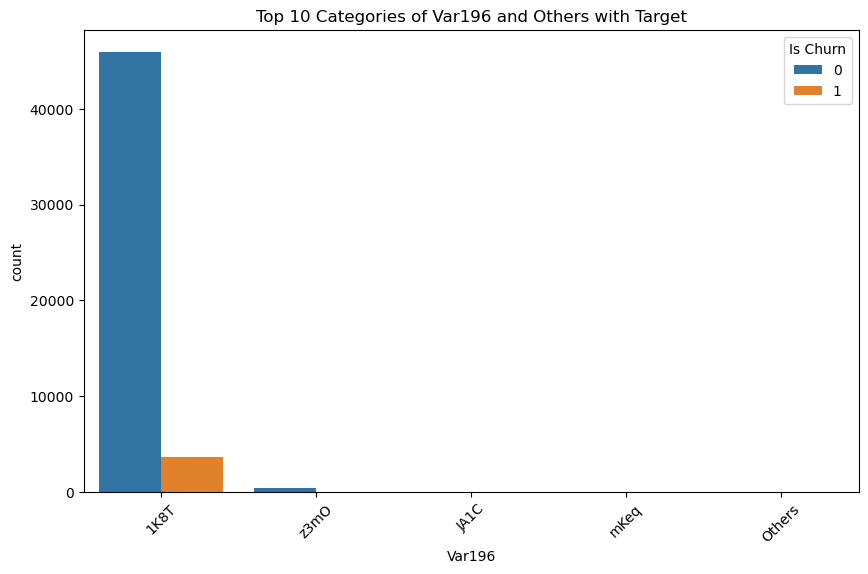

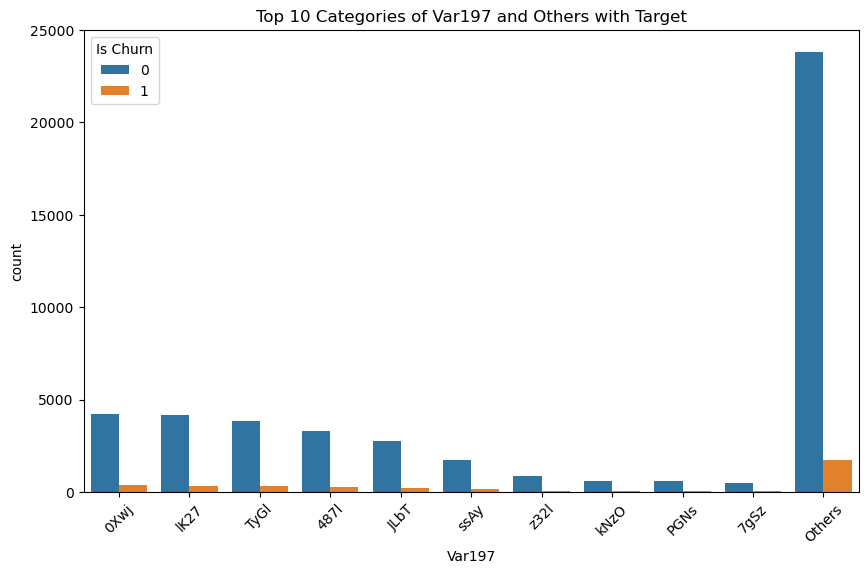

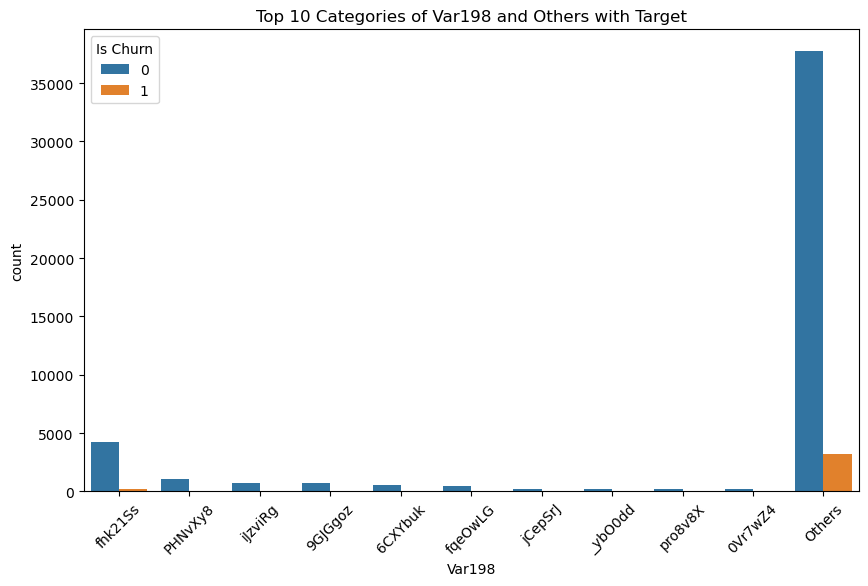

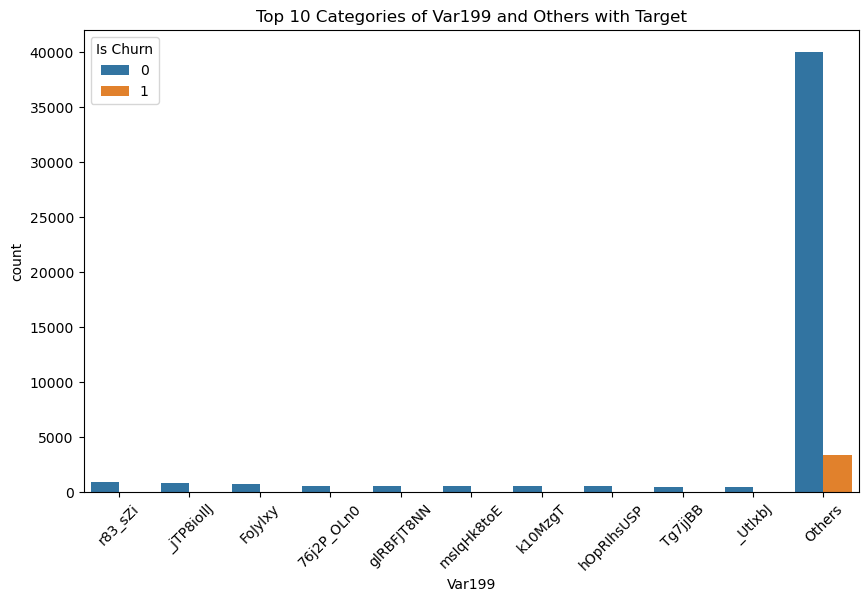

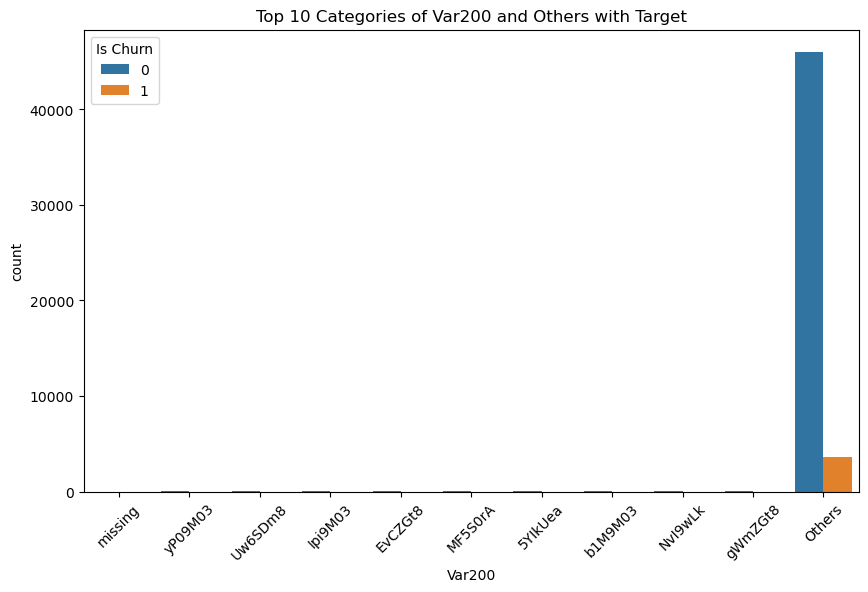

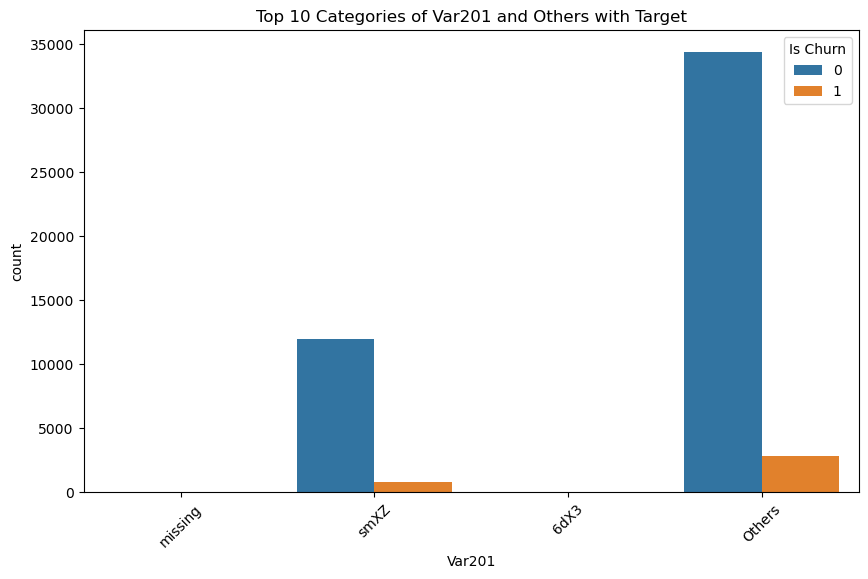

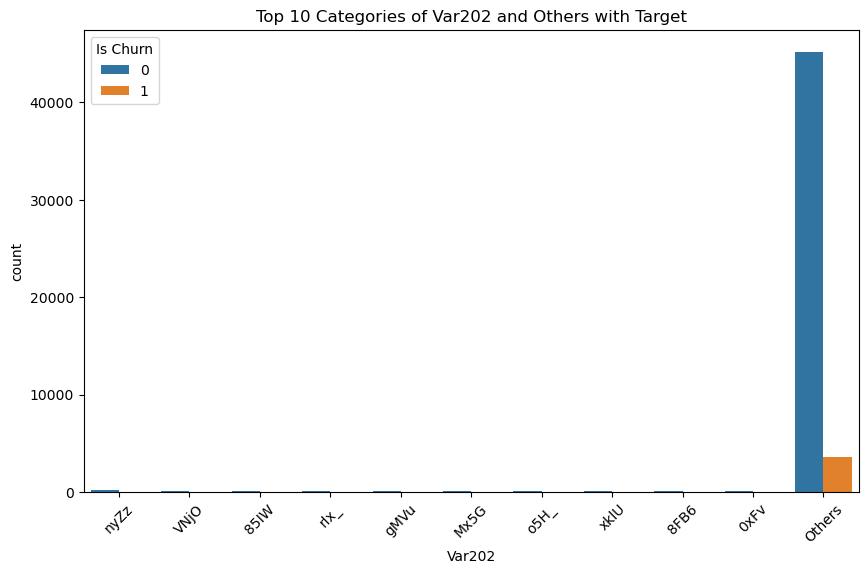

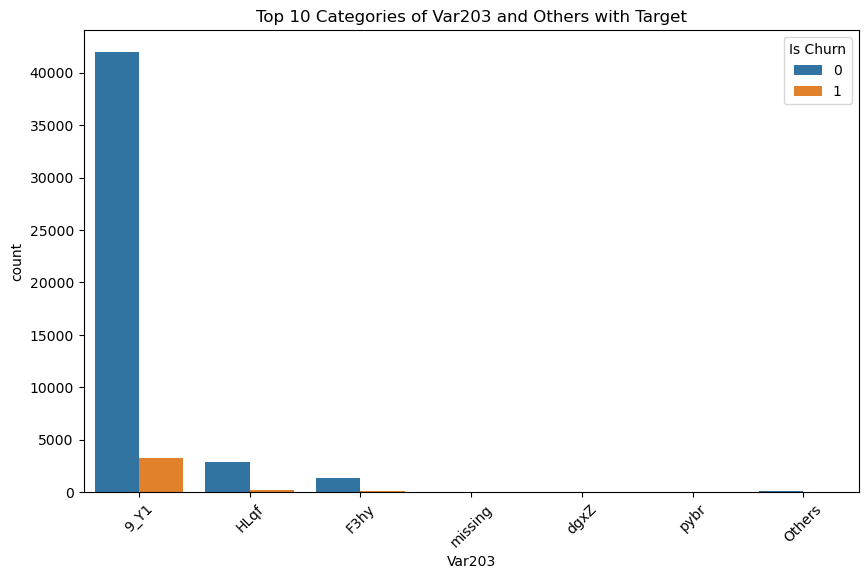

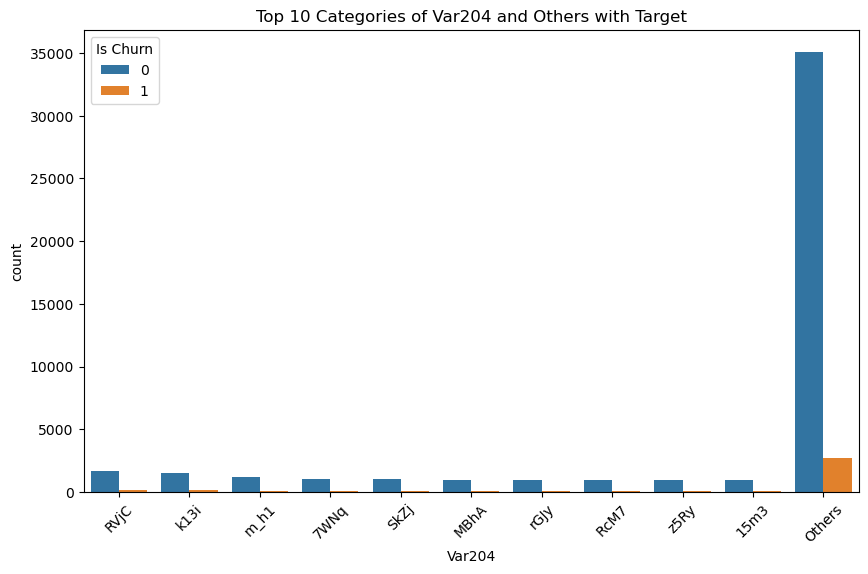

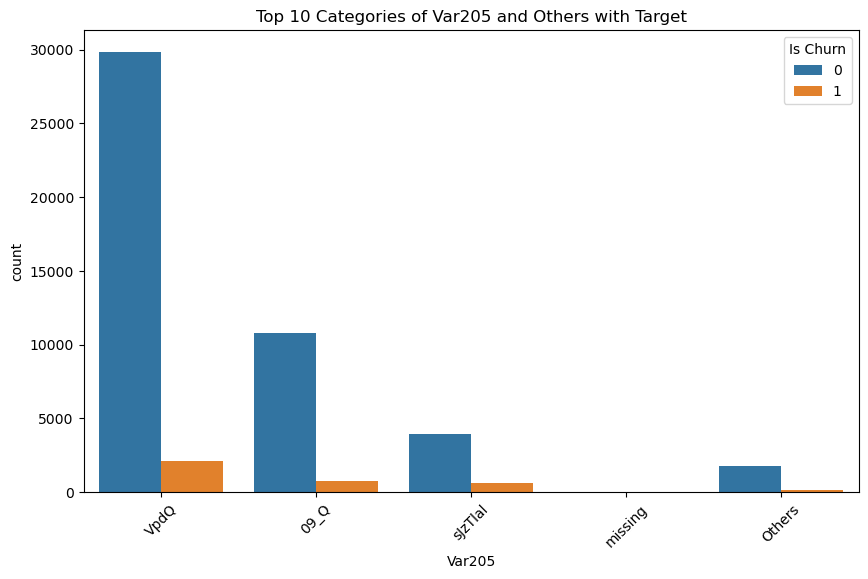

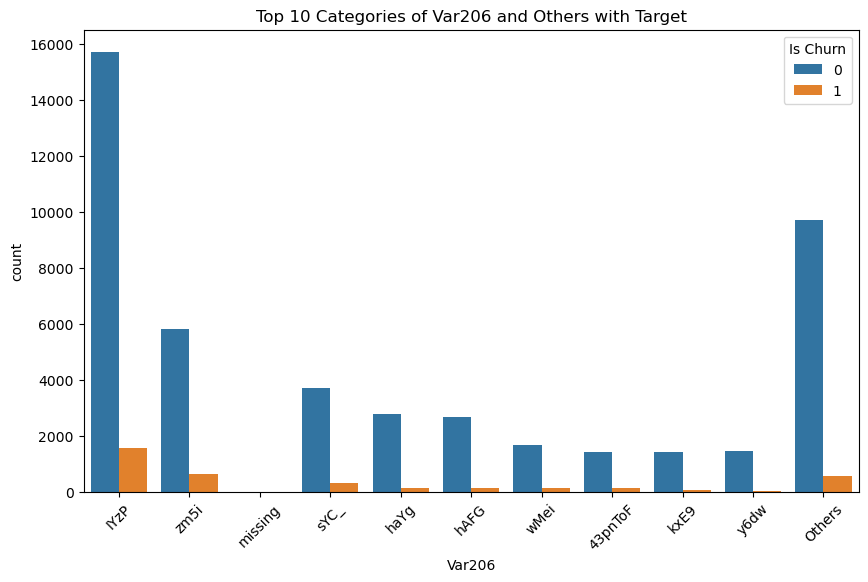

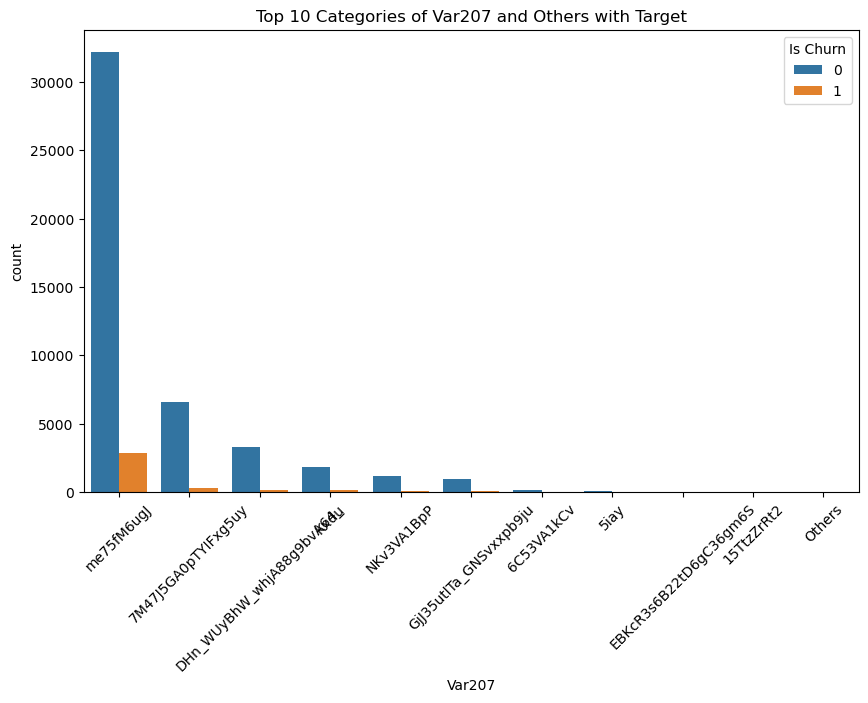

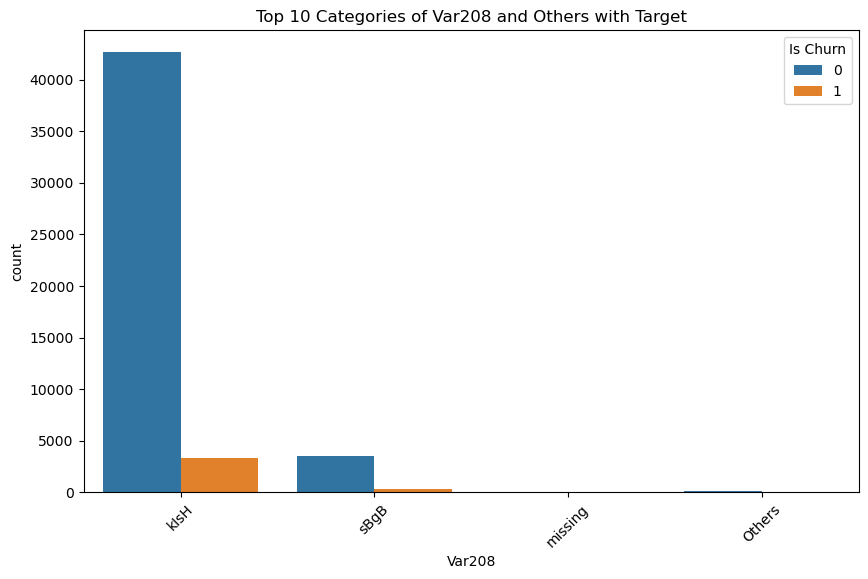

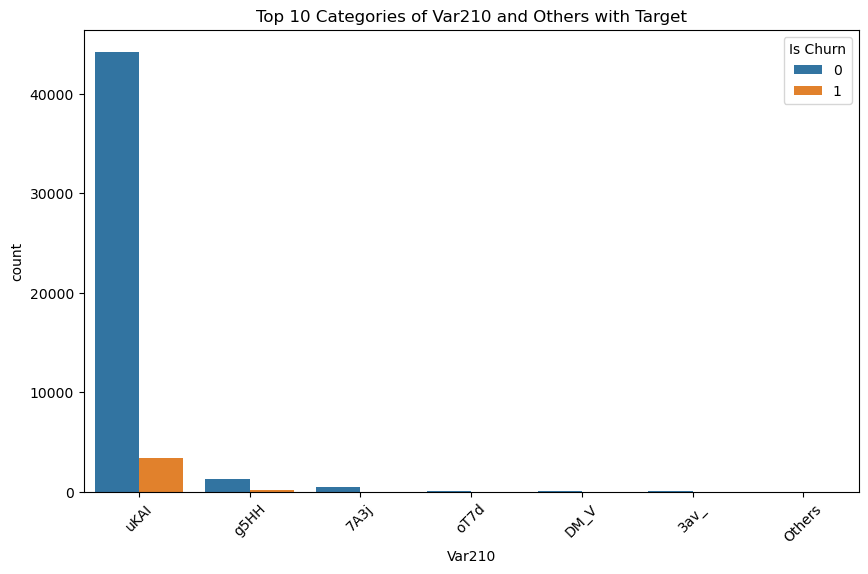

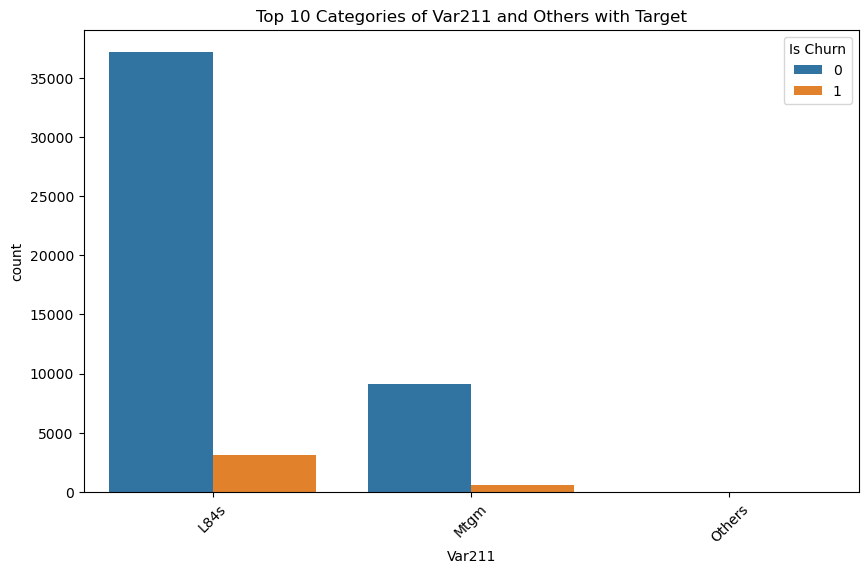

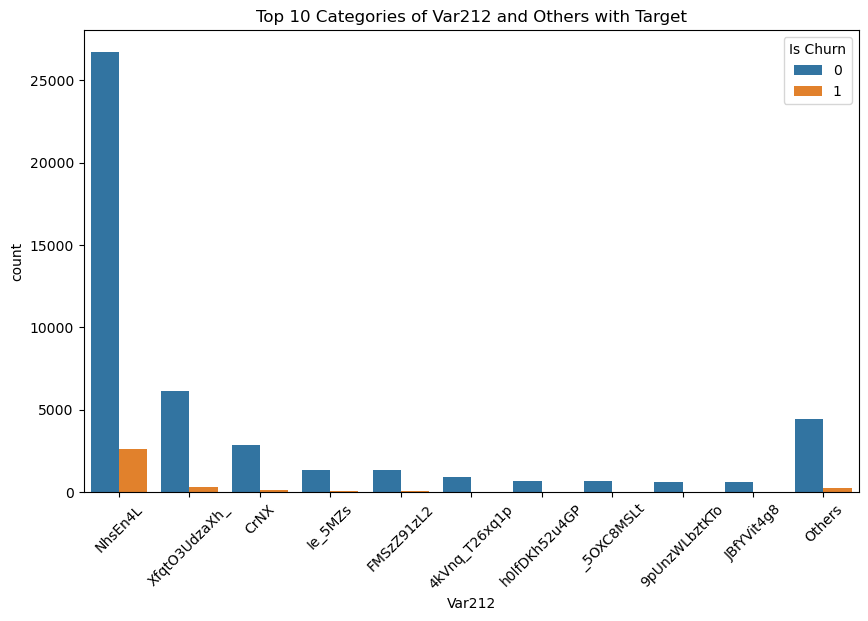

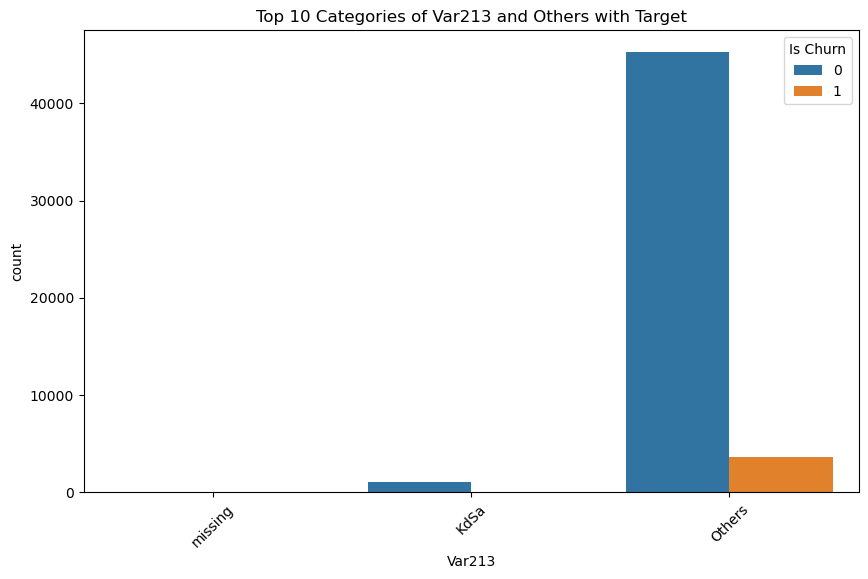

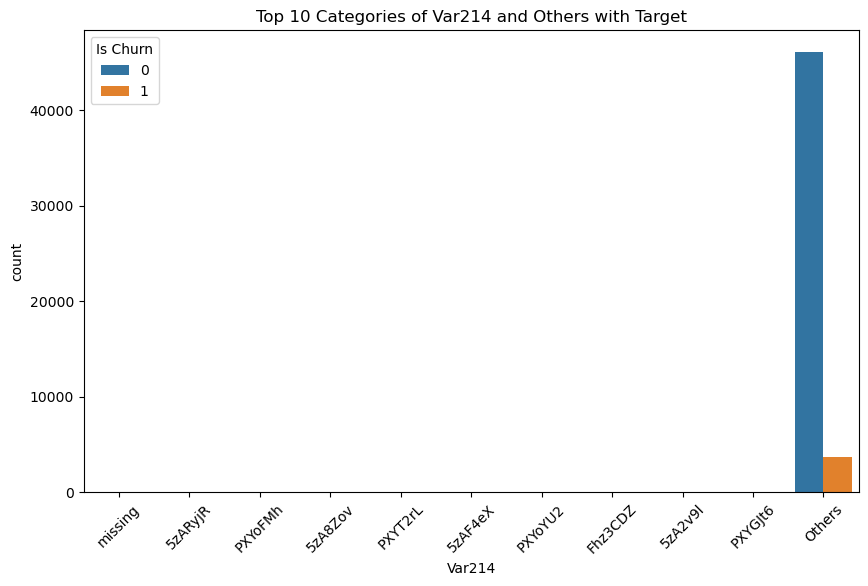

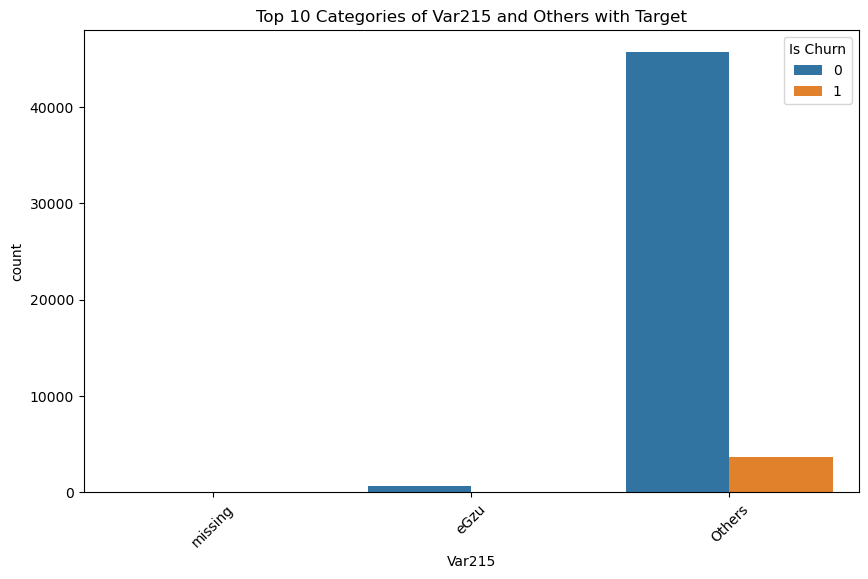

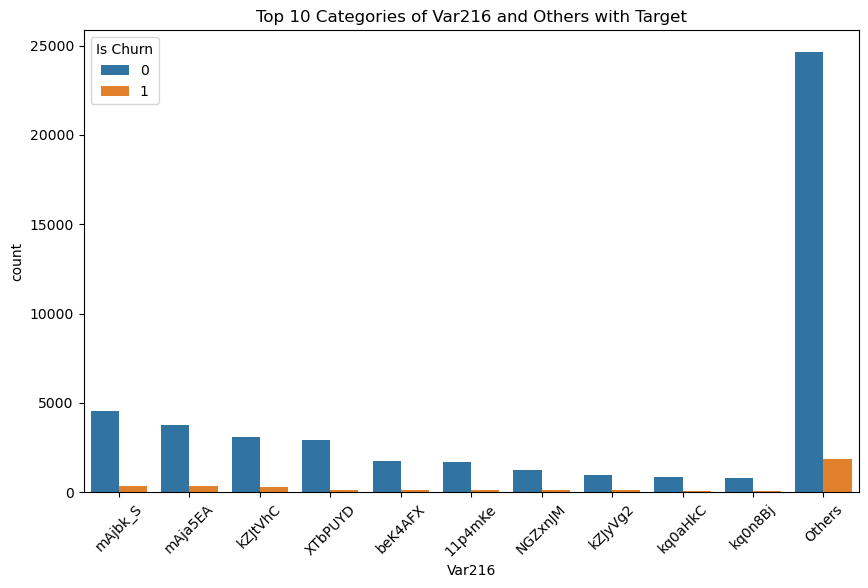

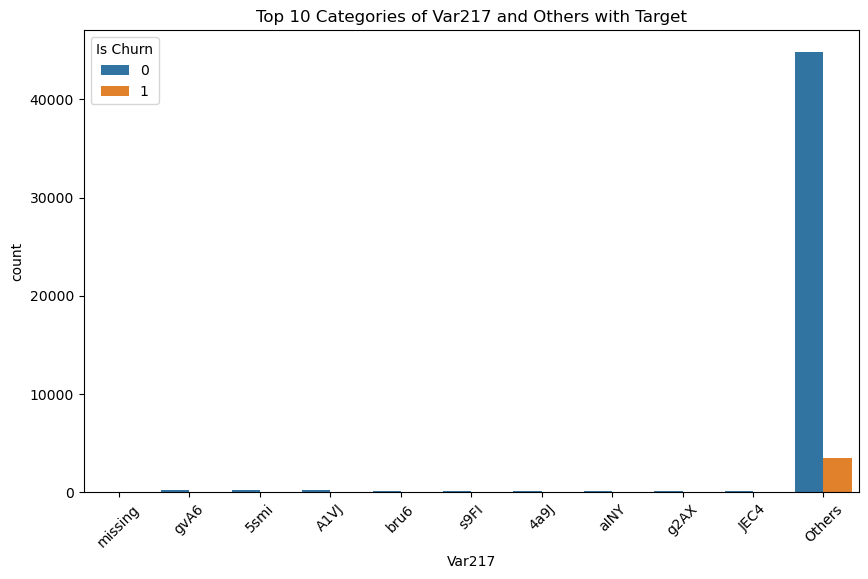

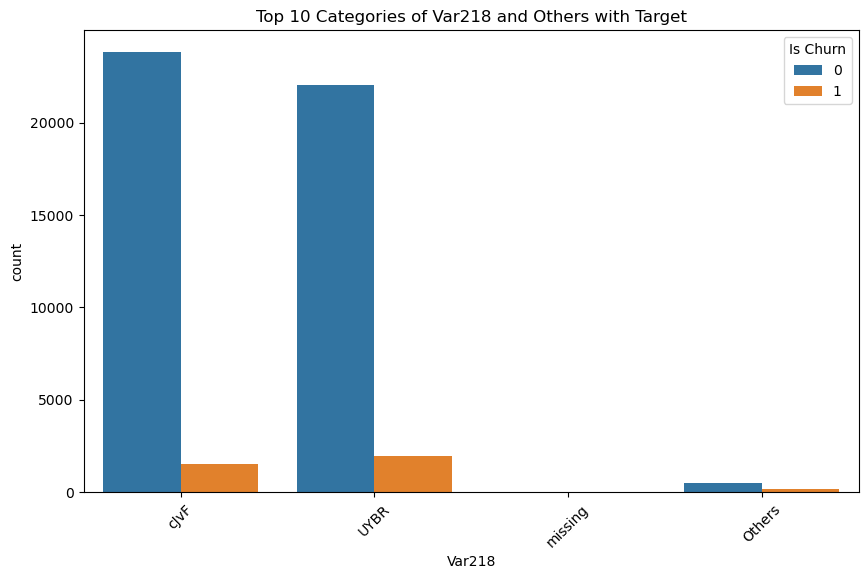

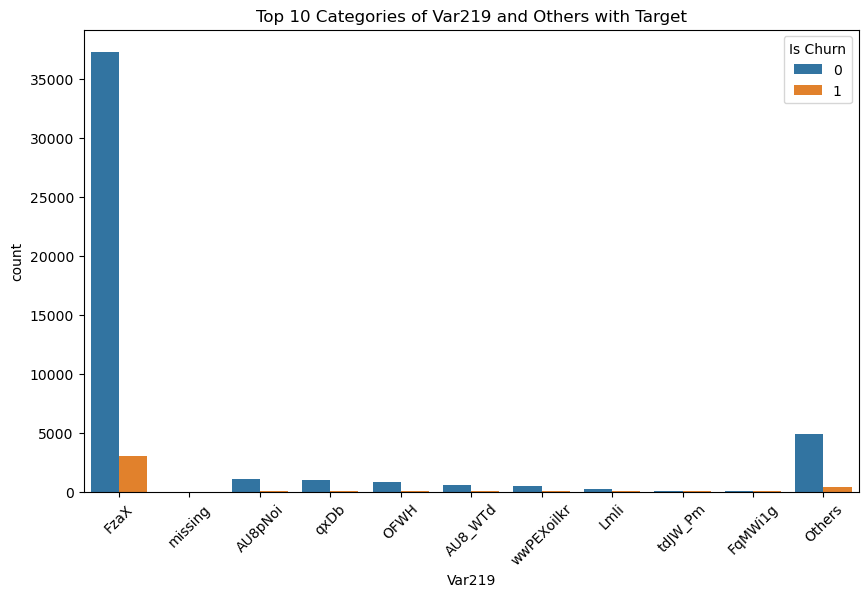

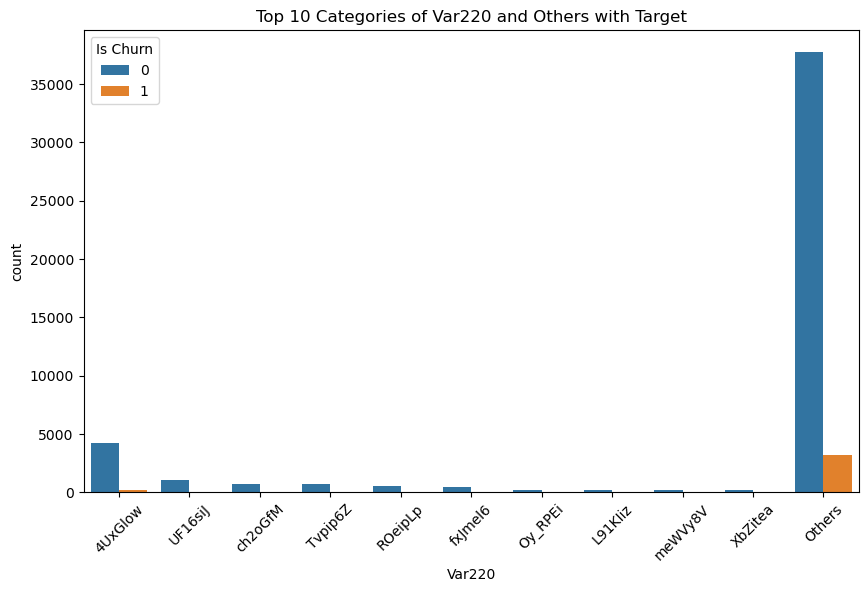

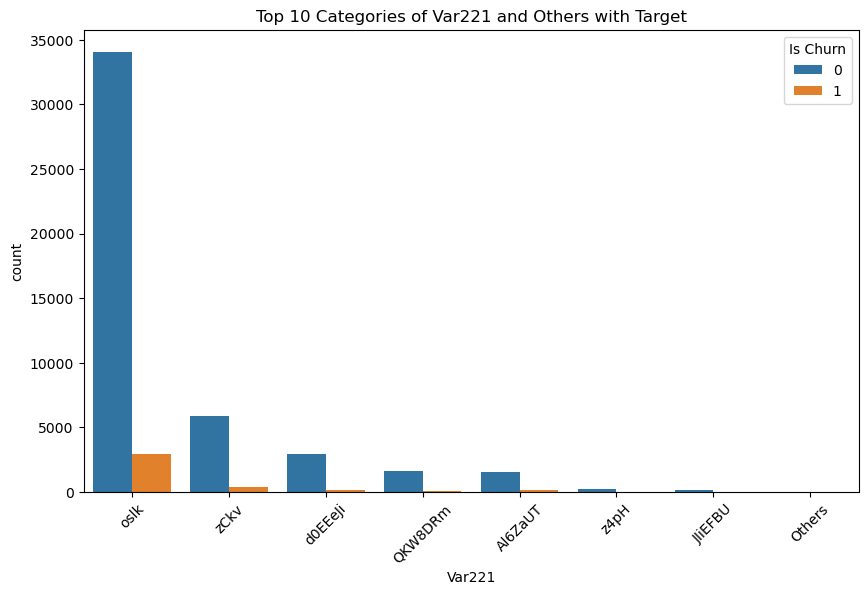

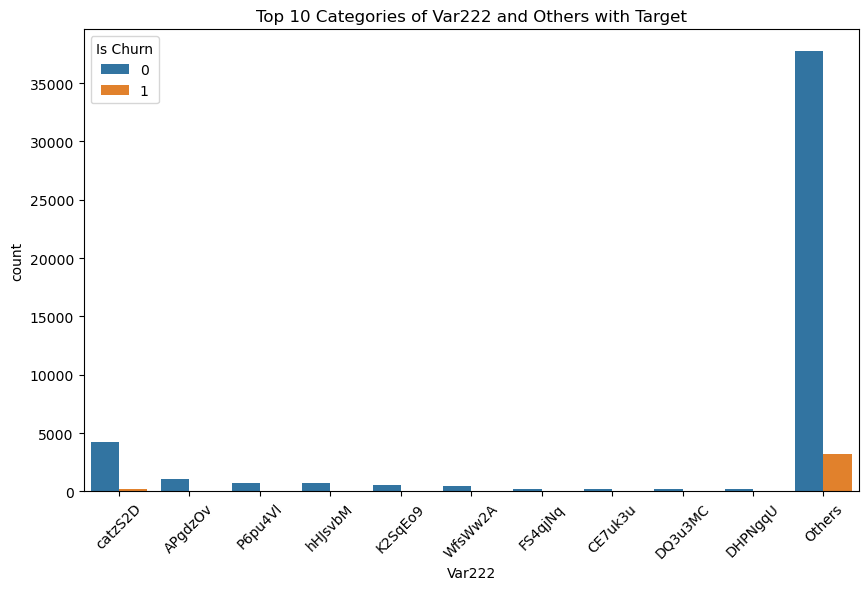

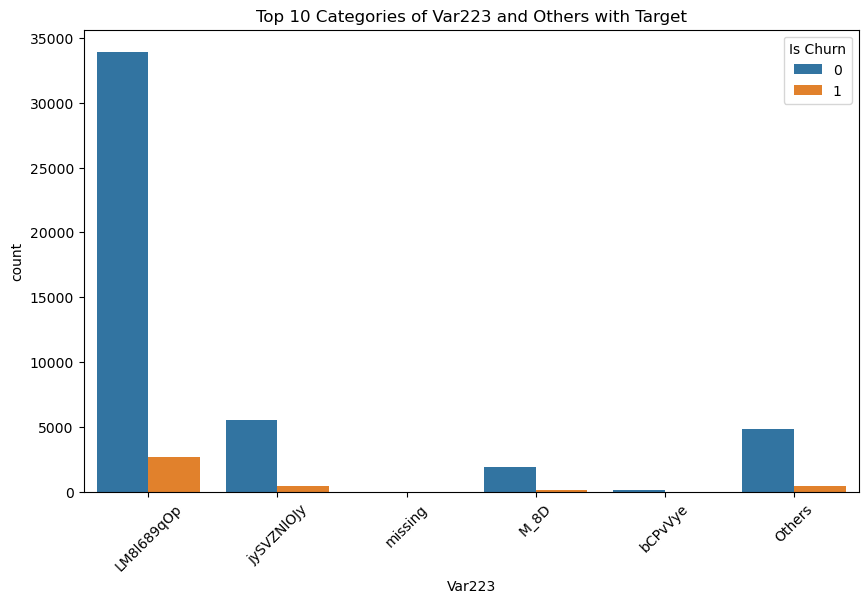

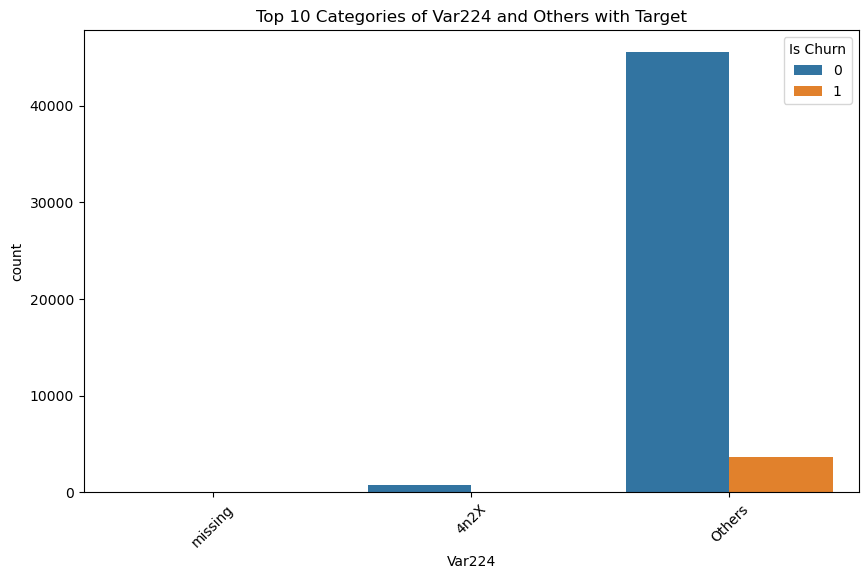

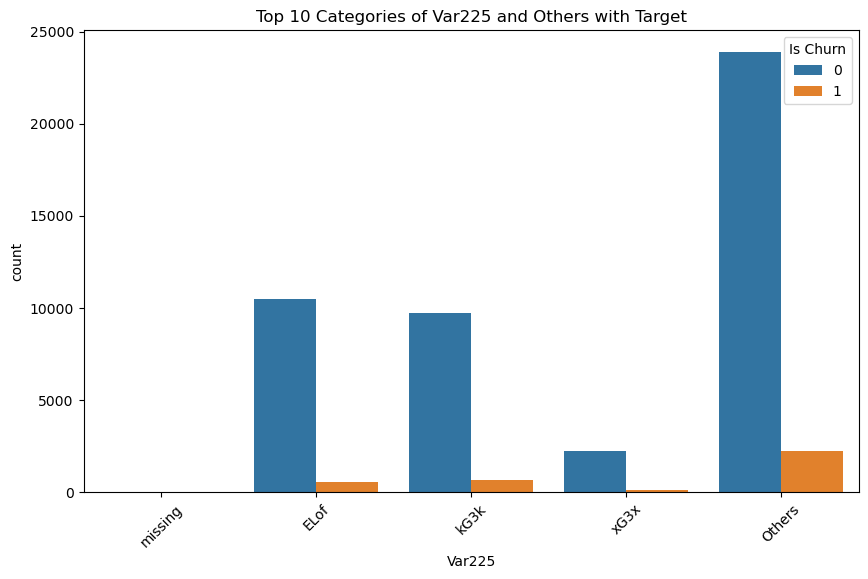

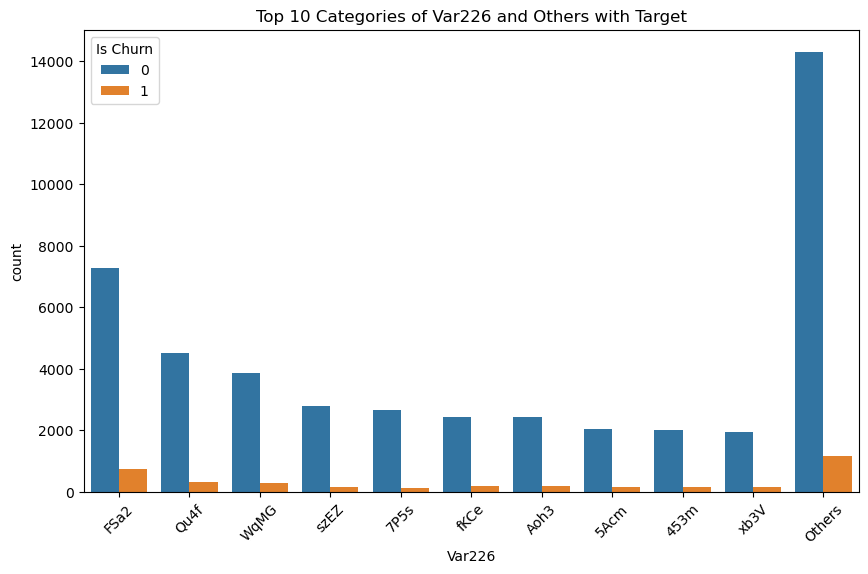

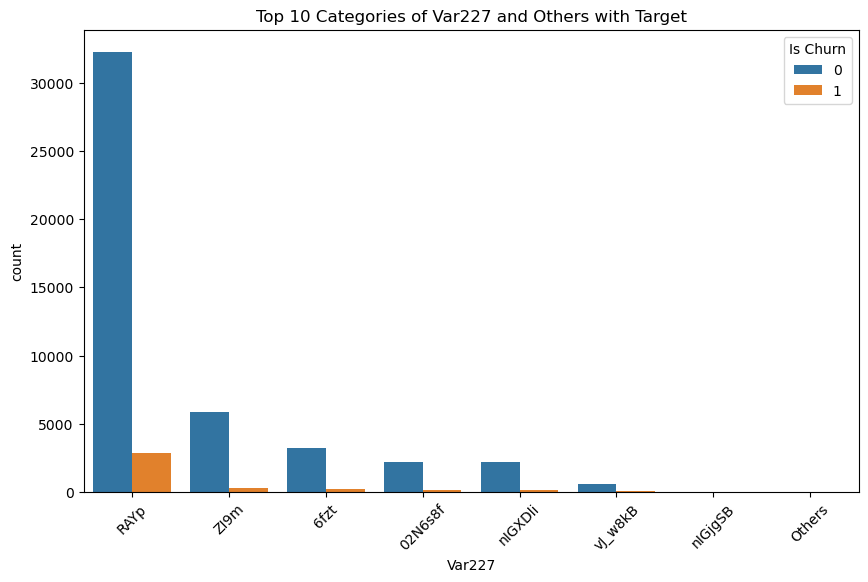

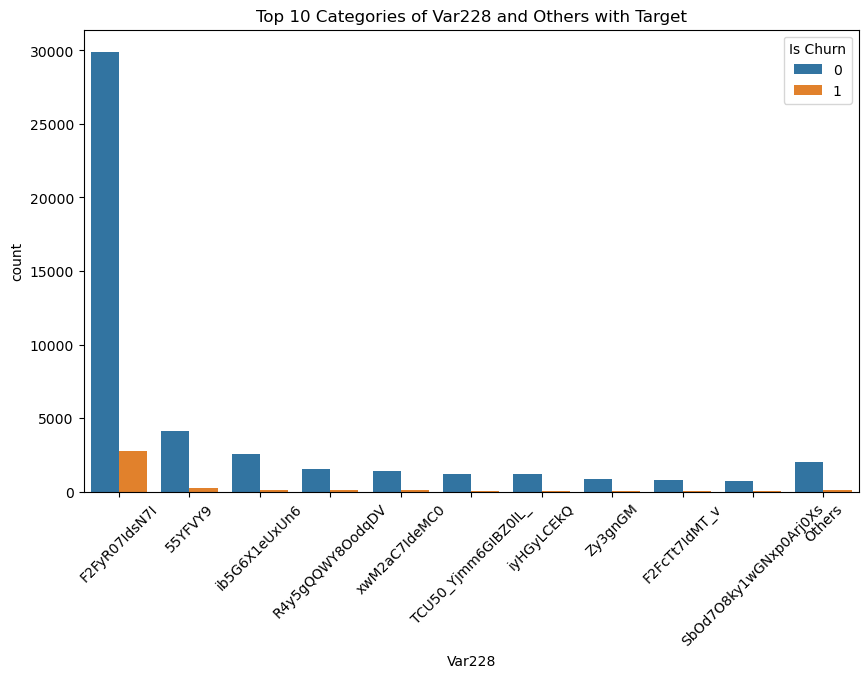

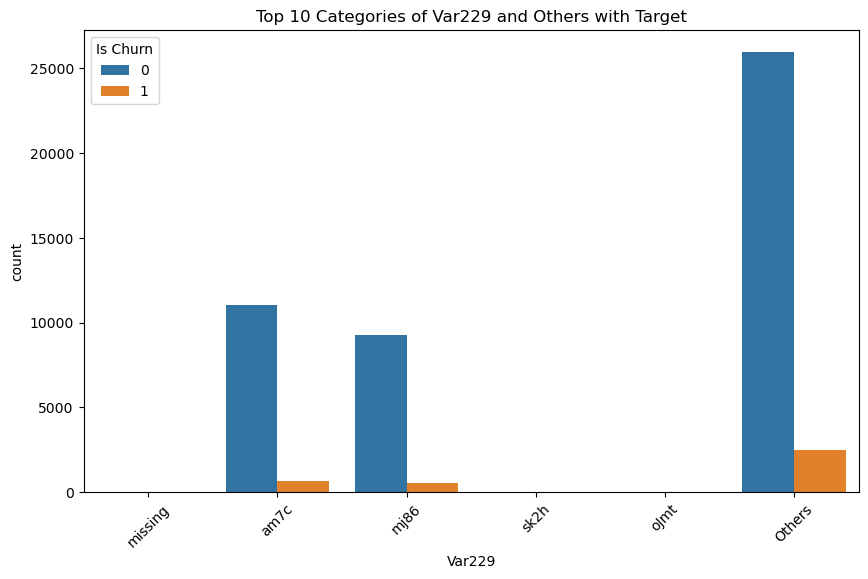

In [24]:
N = 10  
for column in data.select_dtypes(include=['O']).columns:
    # Get the top N categories including NaN values
    top_categories = data[column].fillna('missing').value_counts().nlargest(N)
    
    # Map categories to 'Others' if they are not in the top N
    temp_data = data[column].map(lambda x: x if x in top_categories.index  else 'Others')
    
    # Plotting
    plt.figure(figsize=(10, 6))
    sns.countplot(x=temp_data, hue=data['is_churn'], order=top_categories.index.tolist() + ['Others'])
    plt.title(f'Top {N} Categories of {column} and Others with Target')
    plt.xticks(rotation=45)
    plt.legend(title='Is Churn')
    plt.show()

some categories have just 1 variable and can be discarded. Some categories may have low frequency of occuring but may have impact on the churning decision,we can try different encodings here Top N + others as one-hot encoding,frequency encoding(Weight of Evidence, etc.) 

In [25]:
# Percentage of NaNs w.r.t class
with pd.option_context('display.max_columns', None):
    display(data.isna().groupby(data.is_churn).sum().div(data.is_churn.value_counts(),axis = 0) * 100)

Var1       Var2       Var3       Var4       Var5       Var6  \
is_churn                                                                     
0         98.581851  97.437835  97.439993  96.747108  96.939216  11.345191   
1         98.774510  98.529412  98.529412  98.039216  98.120915   7.434641   

               Var7   Var8       Var9      Var10      Var11      Var12  \
is_churn                                                                 
0         11.325764  100.0  98.581851  96.939216  97.439993  98.875410   
1          7.952070  100.0  98.774510  98.120915  98.529412  98.992375   

              Var13      Var14  Var15      Var16      Var17      Var18  \
is_churn                                                                 
0         11.325764  97.439993  100.0  96.939216  96.747108  96.747108   
1          7.952070  98.529412  100.0  98.120915  98.039216  98.039216   

              Var19  Var20      Var21      Var22      Var23      Var24  \
is_churn                                                                 
0         96.747108  100.0  11.345191  10.293991  96.939216  14.541962   
1         98.039216  100.0   7.434641   6.535948  98.120915  13.425926   

              Var25      Var26      Var27      Var28      Var29      Var30  \
is_churn                                                                     
0         10.293991  96.939216  96.939216  10.298308  98.581851  98.581851   
1          6.535948  98.120915  98.120915   6.535948  98.774510  98.774510   

          Var31  Var32      Var33      Var34      Var35      Var36      Var37  \
is_churn                                                                        
0         100.0  100.0  98.255914  97.437835  10.293991  97.437835  96.747108   
1         100.0  100.0  98.937908  98.529412   6.535948  98.529412  98.039216   

              Var38  Var39      Var40      Var41  Var42      Var43      Var44  \
is_churn                                                                        
0         10.293991  100.0  97.437835  98.581851  100.0  97.437835  10.293991   
1          6.535948  100.0  98.529412  98.774510  100.0  98.529412   6.535948   

              Var45      Var46      Var47  Var48      Var49      Var50  \
is_churn                                                                 
0         99.302797  97.437835  98.581851  100.0  97.437835  98.581851   
1         99.428105  98.529412  98.774510  100.0  98.529412  98.774510   

              Var51  Var52      Var53      Var54  Var55      Var56  Var57  \
is_churn                                                                    
0         92.373942  100.0  98.581851  97.437835  100.0  98.681143    0.0   
1         94.172113  100.0  98.774510  98.529412  100.0  99.046841    0.0   

              Var58      Var59      Var60      Var61      Var62      Var63  \
is_churn                                                                     
0         98.581851  98.329304  96.939216  98.255914  98.875410  98.599119   
1         98.774510  98.747277  98.120915  98.937908  98.992375  98.774510   

              Var64      Var65      Var66      Var67      Var68      Var69  \
is_churn                                                                     
0         99.512174  11.325764  98.599119  96.939216  97.437835  96.939216   
1         99.673203   7.952070  98.774510  98.120915  98.529412  98.120915   

              Var70      Var71      Var72  Var73      Var74      Var75  \
is_churn                                                                 
0         96.939216  97.673113  44.640390    0.0  11.325764  97.437835   
1         98.120915  98.611111  46.269063    0.0   7.952070  98.529412   

              Var76      Var77      Var78  Var79      Var80      Var81  \
is_churn                                                                 
0         10.293991  98.581851  10.293991  100.0  96.939216  11.345191   
1          6.535948  98.774510   6.535948  100.0  98.120915   7.434641   

              Var82   

percentage of nan values seems to be uniform across classes, indicating no patterns here with class labels

Using missing_number library to check for pattern of missingness in the data

In [26]:
temp_data=data[data.columns[(data.isna().sum()/len(data))!=1].drop('is_churn')]

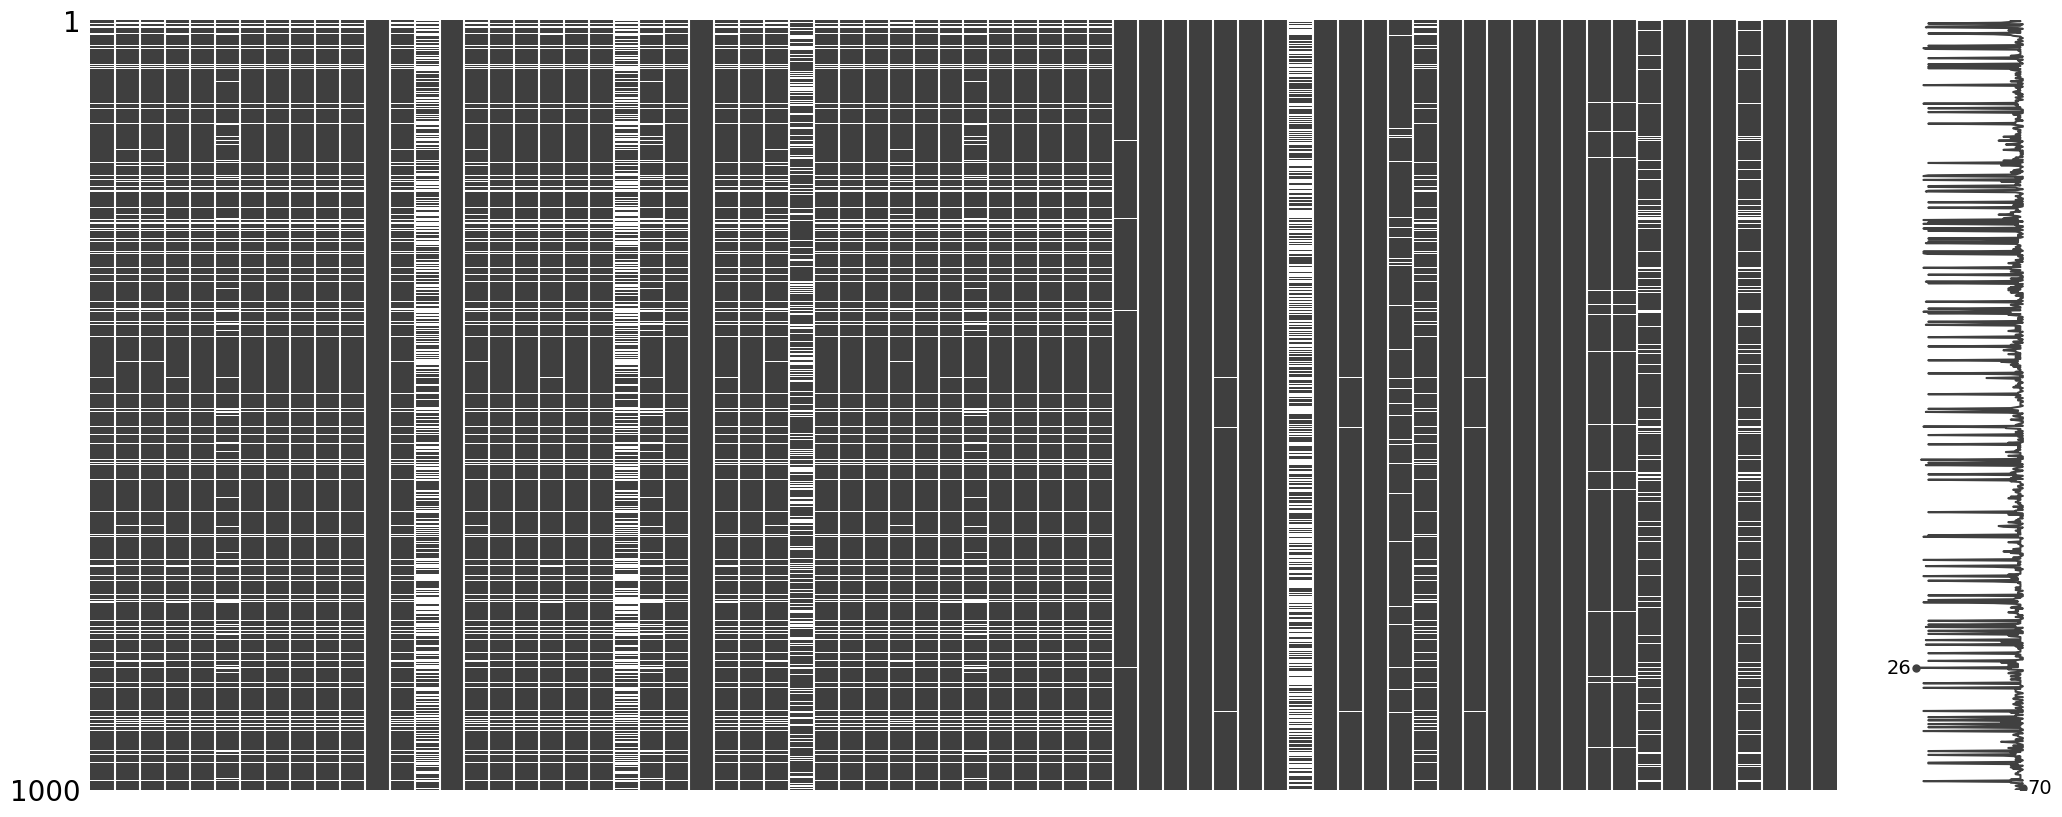

In [27]:
filtered_data = msno.nullity_filter(temp_data, filter='top',n = 70)
msno.matrix(filtered_data.sample(1000))
plt.show()

there seems to be a pattern to this missingness as evident with the white lines between certain variables.

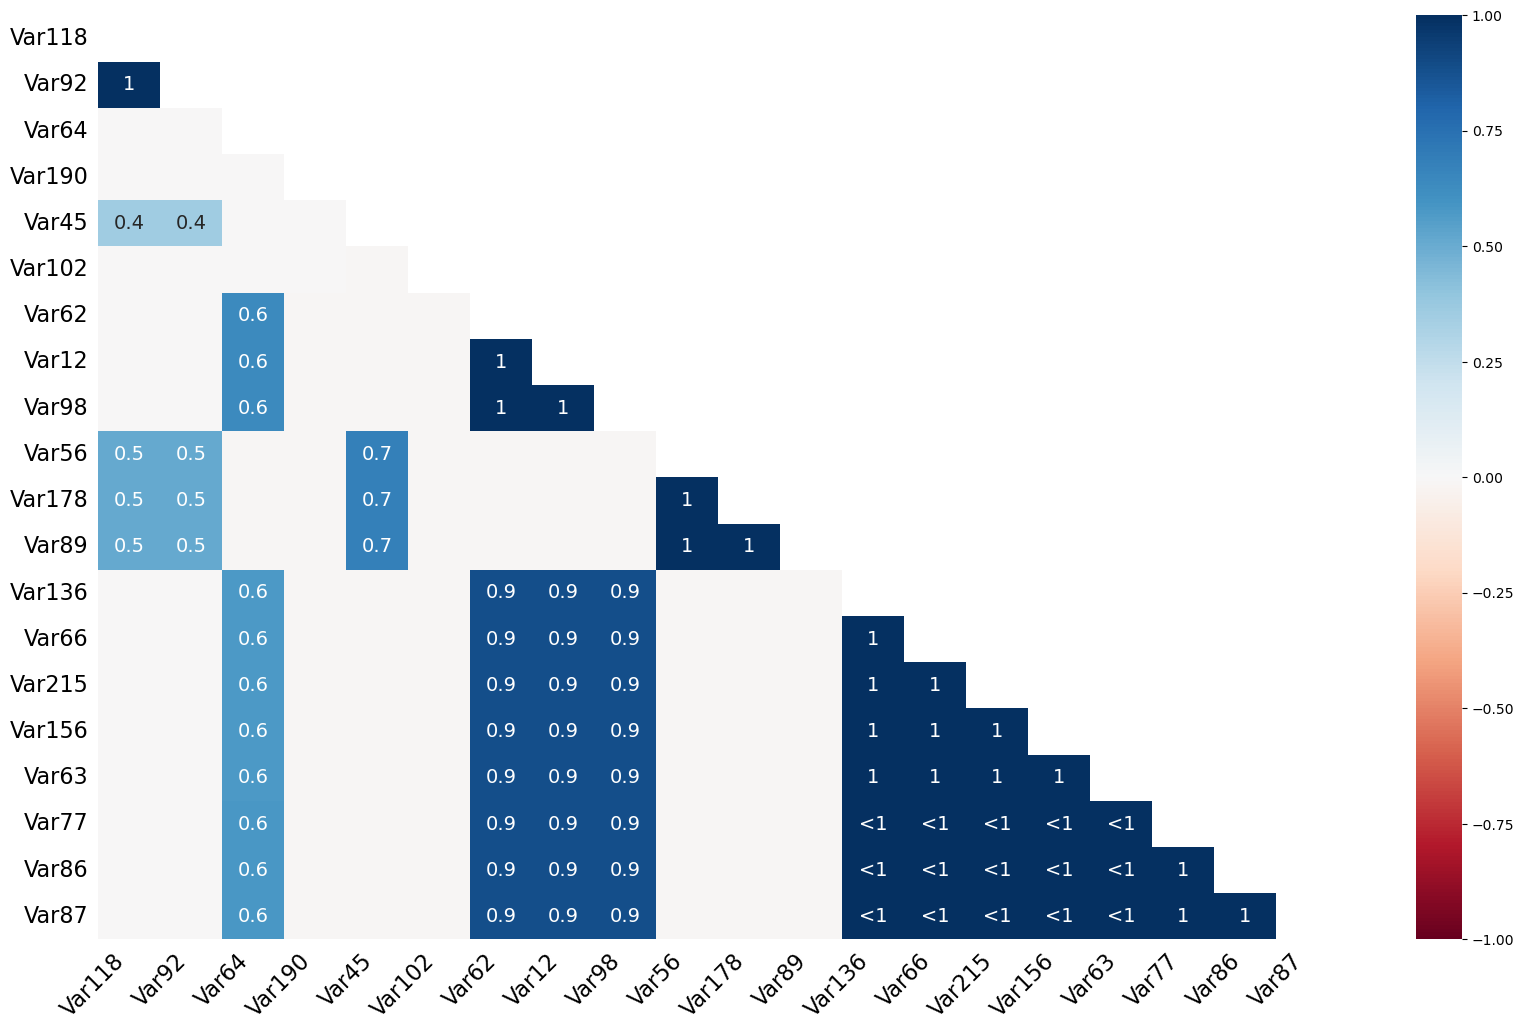

In [28]:
# columns sorted by missing percentages  
high_missing_cols = temp_data.isnull().mean().sort_values(ascending=False).head(20).index

# Heatmap of missingness correlations among highly missing features
msno.heatmap(data[high_missing_cols])
plt.show()

some features seem to have 0 correlation while some seems to have values(0.5,1) suggesting that they might not be missing completly at random(MCAR).Lets investigate further

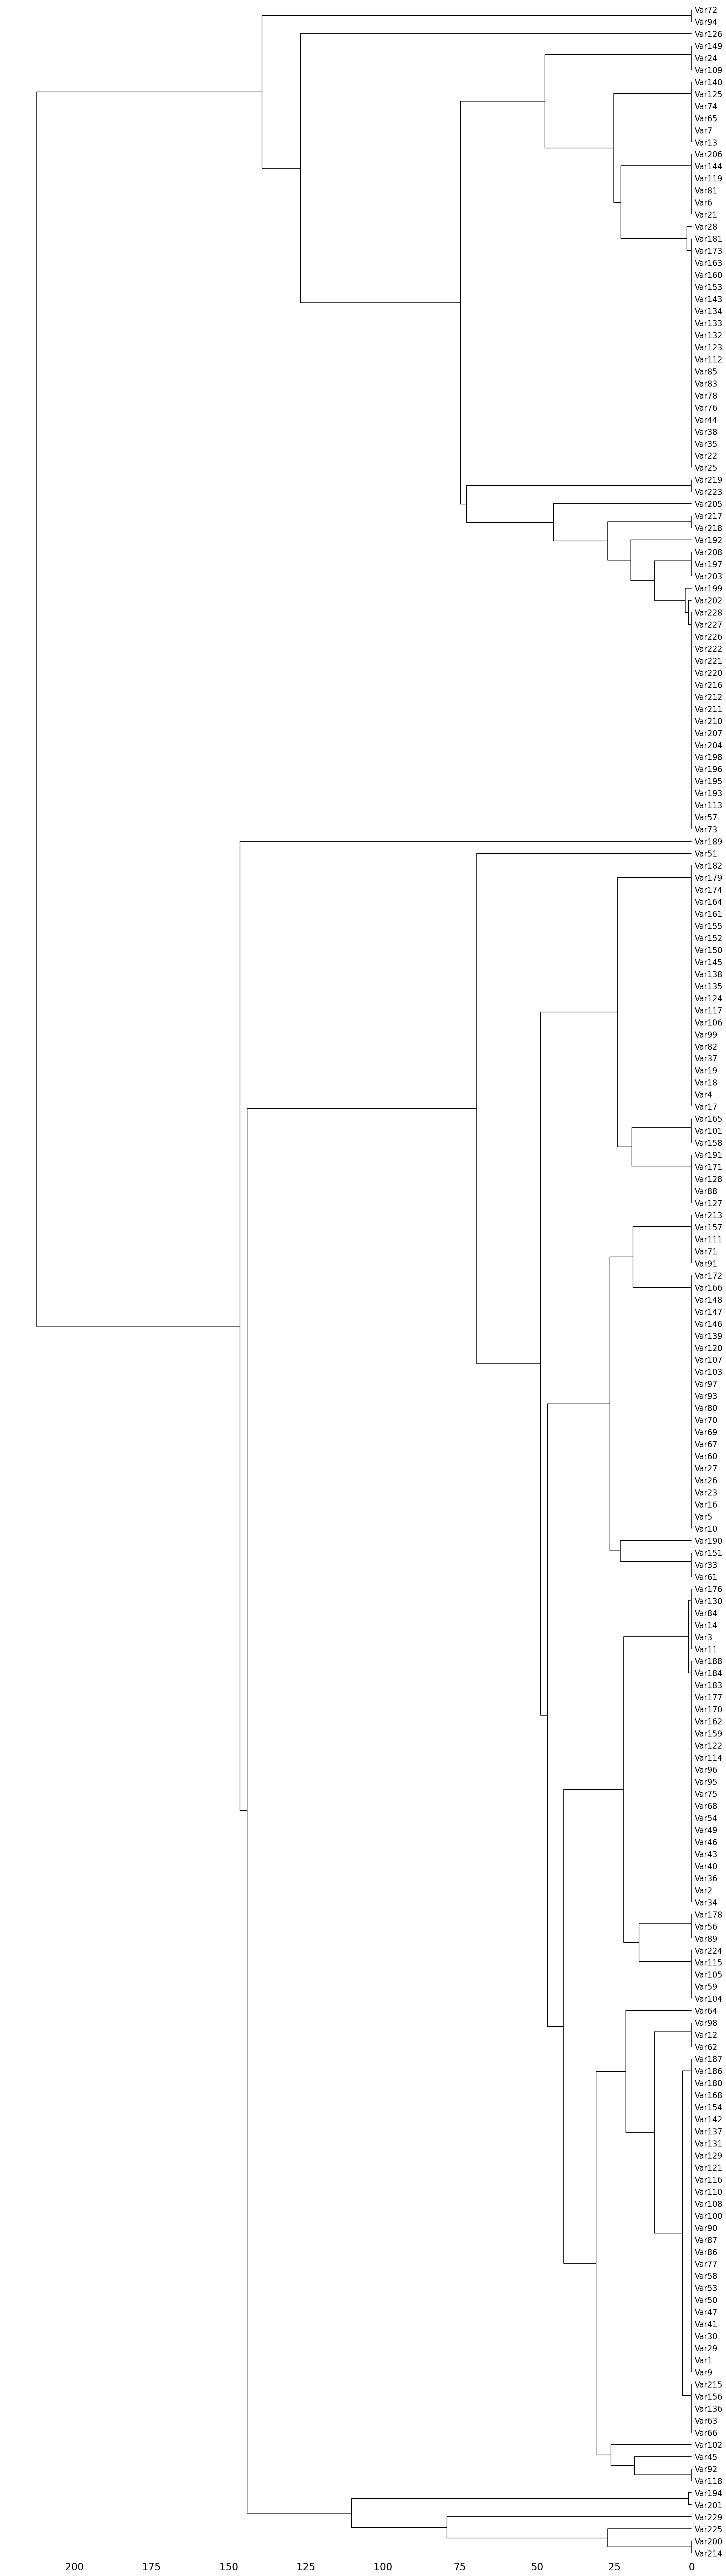

In [29]:
msno.dendrogram(temp_data)
plt.show()

lots of variable seem to be linked at 0 distance suggesting one variable may predict another's presence.

- It is evident the variable are not missing completly at random and missingness may be based on other variables which implies we cant disregard this and would need to impute it 
- still we can try removing features at certain threshold of missingness and try working with those variables

In [30]:
for threshold in np.arange(0.5, 1, 0.1):
    print(f'Number of columns with NaN <= {threshold*100:.0f}%:', data.loc[:, data.isna().mean() <= threshold].shape[1])

Number of columns with NaN <= 50%: 70
Number of columns with NaN <= 60%: 75
Number of columns with NaN <= 70%: 75
Number of columns with NaN <= 80%: 77
Number of columns with NaN <= 90%: 77


threshold of 60% gives 75 columns, this can be a start

### PRE-PROCESSING

In [31]:
temp_data=data.copy(deep=True)

In [32]:
temp_data.drop_duplicates(inplace=True)
temp_data.dropna(how='all',inplace=True)
temp_data = temp_data.loc[:, temp_data.isna().mean() <= 0.6]

### Feature Engineering

#### Binning Numerical Variables 

As Var 73 showed evidence of being a multimodal distibution we will bin the varable in steps of 25 sample.Also then we will oridnal encode it based on the peakedness

In [39]:
# binning var_73 as it showed a multimodal distribution
def bin_variable(df, column,bins,labels):
    df2 = df.copy()
    df2[column] = pd.cut(df2[column], bins=bins, labels=labels)
    return df2

In [40]:
bins = [0, 25, 50, 75, 100, 125, 150, 175, 200, 225, 250, np.inf]
labels = ['1-25', '26-50', '51-75', '76-100', '101-125', '126-150', '151-175', '176-200', '201-225', '226-250', '251+']
temp_data = bin_variable(temp_data,'Var73',bins,labels) 

ordinal_encoder = OrdinalEncoder()
temp_data['Var73'] = ordinal_encoder.fit_transform(temp_data[['Var73']])

#### Binning Categories

- As the dataset has multiple granular categories some of them can be binned as 'others'.
- Low cardinality variables can be one hit encoded whereas for high cardinality we can use bayesian encoding such as WOE
- as we plan on using bayesian encoding we would need to consider the minimum number of samples per class, so that the granular level categories don't cause overfitting(classes with 1,2,3 samples could overfit)  

for stable results let us assume that minimum number of samples per category should be 5,then we divide it by event rate(possitive) and not event rate to get the minimum samples required

In [41]:
event_rate = temp_data['is_churn'].mean()
non_event_rate = 1 - event_rate

# minimum number of samples per category for stable encoding
min_samples = max(5 / event_rate, 5 / non_event_rate)
print(f"Minimum number of samples per category for WoE: {min_samples}")

Minimum number of samples per category for WoE: 68.08278867102396


The following function bins the category to 'Other' based on two conditions:
1. The sum of proportions on unique value should be equal to the threshold (ie. if variable x contain a,b,c,d. a(0.75)+b(0.15)+c(0.5)+d(0.5)=1, then after applying the function categories become a,b,others).
2. min samples per category should be greater than 68

In [42]:
def create_category_mapping(df, threshold=0.85, min_sample_size=68):
    
    category_mappings = {}
    def bin_categories(df, column, threshold, min_sample_size):
        counts = df[column].value_counts(dropna=False)
        proportions = counts / len(df[column])
        cumulative_sum = 0
        categories_to_keep = []

        for category, count in counts.items():
            if count < min_sample_size:
                continue
            cumulative_sum += proportions[category]
            categories_to_keep.append(category)
            if cumulative_sum >= threshold:
                break

        if not categories_to_keep:
            categories_to_keep.append(counts.idxmax())

        category_mappings[column] = categories_to_keep

    for column in df.select_dtypes(include=['object']).columns:
        bin_categories(df, column, threshold, min_sample_size)

    return category_mappings
    
def apply_category_mapping(df, category_mappings):
    df_copy = df.copy()
    for column, categories_to_keep in category_mappings.items():
        df_copy[column] = df_copy[column].apply(lambda x: x if x in categories_to_keep else 'Others')
    return df_copy    

In [43]:
category_mappings = create_category_mapping(temp_data, threshold=0.8)
temp_data = apply_category_mapping(temp_data, category_mappings)

This code encodes values of low cardinality

In [44]:
def encode_low_cardinality(df, max_value=8):
    df_copy = df.copy()
    categorical_columns = df_copy.select_dtypes(include=['object']).columns
    ohe_mapping = {}
    
    for column in categorical_columns:
        if df_copy[column].nunique() <= max_value:
            one_hot_encoder = OneHotEncoder(sparse=False, drop='first')
            one_hot_encoded = one_hot_encoder.fit_transform(df_copy[[column]])
            one_hot_encoded_df = pd.DataFrame(one_hot_encoded, columns=one_hot_encoder.get_feature_names_out([column]))
            df_copy = pd.concat([df_copy, one_hot_encoded_df], axis=1)
            df_copy.drop(column, axis=1, inplace=True)
            ohe_mapping[column] = one_hot_encoder
    
    return df_copy, ohe_mapping

In [45]:
temp_data, ohe_mapping = encode_low_cardinality(temp_data)
temp_data.select_dtypes(include='O').fillna('Unknown', inplace=True)

The following code add binary flag for nan values in numerical variables

In [46]:
# add flags for missing numeric variables
def flag_numeric(df):
    na_flags = []
    for column_name in df.columns:
        if pd.api.types.is_numeric_dtype(df[column_name]):
            if df[column_name].isna().any():
                df[column_name + '_na'] = df[column_name].isna()
                na_flags.append(column_name + '_na')
    return df, na_flags

In [47]:
temp_data, na_flags = flag_numeric(temp_data)

the following function checks if categories contain duplicate mapping.(ie A contains values -> 0,1 and B also contains -> 0,1 and if A(0)->B(0) & A(1)->B(1) it will identify it as duplicate mapping)

In [48]:
def get_duplicate_mapping(df):
    duplicate_features_groups = []
    checked_features = set()

    for i, feature1 in enumerate(df.columns):
        if feature1 not in checked_features:
            duplicates = [feature1]
            for feature2 in df.columns[i + 1:]:
                if feature2 not in checked_features:
                    if df[feature1].nunique(dropna=False) == df[feature2].nunique(dropna=False):
                        if df[feature1].equals(df[feature2]):
                            duplicates.append(feature2)
                        elif df[[feature1, feature2]].drop_duplicates().shape[0] == df[feature1].nunique(dropna=False):
                            duplicates.append(feature2)
            if len(duplicates) > 1:
                duplicate_features_groups.append(duplicates)
                checked_features.update(duplicates)

    return duplicate_features_groups


In [49]:
get_duplicate_mapping(temp_data)

[['Var198', 'Var220', 'Var222'],
 ['Var200_nan', 'Var214_nan'],
 ['Var206_nan', 'Var6_na', 'Var21_na', 'Var81_na', 'Var119_na', 'Var144_na'],
 ['Var7_na', 'Var13_na', 'Var65_na', 'Var74_na', 'Var125_na', 'Var140_na'],
 ['Var22_na',
  'Var25_na',
  'Var35_na',
  'Var38_na',
  'Var44_na',
  'Var76_na',
  'Var78_na',
  'Var83_na',
  'Var85_na',
  'Var112_na',
  'Var123_na',
  'Var132_na',
  'Var133_na',
  'Var134_na',
  'Var143_na',
  'Var153_na',
  'Var160_na',
  'Var163_na',
  'Var173_na',
  'Var181_na'],
 ['Var24_na', 'Var109_na', 'Var149_na'],
 ['Var72_na', 'Var94_na']]

We can keep one variable from the duplicate mapping and drop the rest 

In [50]:
duplicate_groups=get_duplicate_mapping(temp_data)
duplicate_groups = [feature for group in duplicate_groups for feature in group[1:]]
temp_data=temp_data.drop(duplicate_groups,axis=1)

#### Splitting Data

In [65]:
X_train, X_test, y_train, y_test = train_test_split(temp_data.drop('is_churn',axis=1),temp_data['is_churn'], 
                                                                            test_size = 0.2, stratify = temp_data['is_churn'], 
                                                                            random_state=9)

for rest of the variables we will use **Weight of Evidence** encoding

In [66]:
woe_encoder = ce.WOEEncoder(cols=X_train.select_dtypes('O').columns)

X_train[X_train.select_dtypes('O').columns] = woe_encoder.fit_transform(X_train.select_dtypes('O'),y_train)
X_test[X_test.select_dtypes('O').columns] = woe_encoder.transform(X_test.select_dtypes('O'))

The missing values showed correlation,so imputing missing values **[MICE](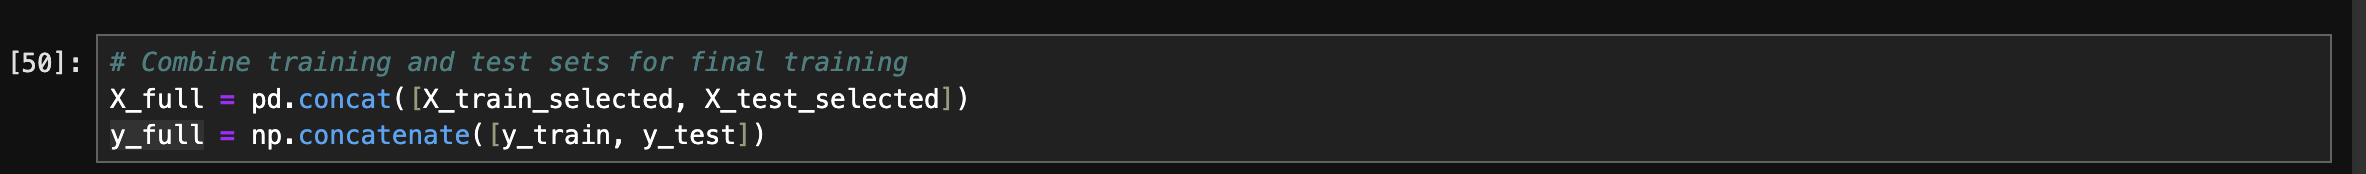)**(Multiple imputation by chained equations) may be benficial

In [ ]:
# Impute missing values in numerical features using Iterative Imputer 
imp = IterativeImputer(missing_values=np.nan,random_state=9, n_nearest_features=5 ,max_iter=10)
X_train.loc[:, X_train.columns] = imp.fit_transform(X_train)
X_test.loc[:, X_test.columns]=imp.transform(X_test)

### Building Model

In [ ]:
def evaluate_model(model, X_train, y_train, X_test, y_test, cv=10):
    # Cross-validation predictions
    skf = StratifiedKFold(n_splits=cv, shuffle=True, random_state=9)
    y_train_pred_proba_cv = cross_val_predict(model, X_train, y_train, cv=skf, method='predict_proba')[:, 1]
    
    # Fit the model
    model.fit(X_train, y_train)
    
    # Predictions
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    y_train_proba = model.predict_proba(X_train)[:, 1]
    
    # Evaluation metrics
    roc_auc = roc_auc_score(y_test, y_pred_proba)
    print("model ROC-AUC score on test set:", roc_auc)
    print(classification_report(y_test, y_pred))
    
    # Cross-validated ROC-AUC score
    roc_auc_cv = cross_val_score(model, X_train, y_train, cv=skf, scoring='roc_auc')
    print("Cross-validated ROC-AUC scores:", roc_auc_cv)
    print("Mean Cross-validated ROC-AUC score:", roc_auc_cv.mean())
    
    # Plot ROC curves for training, test sets, and cross-validated training set
    tr_fpr, tr_tpr, _ = roc_curve(y_train, y_train_proba)
    te_fpr, te_tpr, _ = roc_curve(y_test, y_pred_proba)
    cv_fpr, cv_tpr, _ = roc_curve(y_train, y_train_pred_proba_cv)
    
    plt.figure(figsize=(10, 6))
    plt.plot(tr_fpr, tr_tpr, label='Train AUC score')
    plt.plot(te_fpr, te_tpr, label='Test AUC score')
    plt.plot(cv_fpr, cv_tpr, label='CV AUC score', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
    plt.title('ROC Curve for Churn (Random Forest)')
    plt.grid()
    plt.show()
    
    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.show()
    
    return roc_auc, roc_auc_cv.mean(), cm

#### Baseline Model

- let's create a baseline model with Randomforest. why?
    - There are multiple models which can be considered (logistic regression,Naive Bayes,Rule_Based classifiers,Gradient boosting) but given the nature of this data too many numerical variables of unknown scales and having outliers, many granular categories to many missing values showing correlation in missingness. Capturing this with simple models like logistic regression,Naive Bayes mat prove challenging, therefore a robust model which requires minimum preprocessing and that would genralise well.
- For evaluating we will consider classification report as this is imbalanced set and we are concerned with minority class, ROC score and AUC-ROC curve to compare models and check for overfitting and also have a look at the classification matrix 

model ROC-AUC score on test set: 0.6950790914132768
              precision    recall  f1-score   support

           0       0.93      1.00      0.96      9266
           1       0.33      0.00      0.00       734

    accuracy                           0.93     10000
   macro avg       0.63      0.50      0.48     10000
weighted avg       0.88      0.93      0.89     10000

Cross-validated ROC-AUC scores: [0.7163585  0.71947823 0.74450652 0.7297139  0.69425109 0.69477929
 0.72393177 0.70293622 0.7431569  0.67755267]
Mean Cross-validated ROC-AUC score: 0.7146665097928249


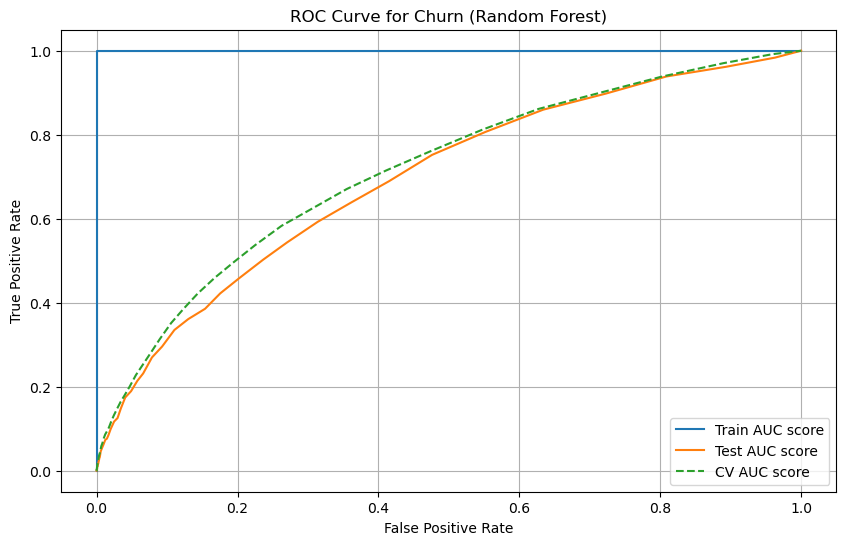

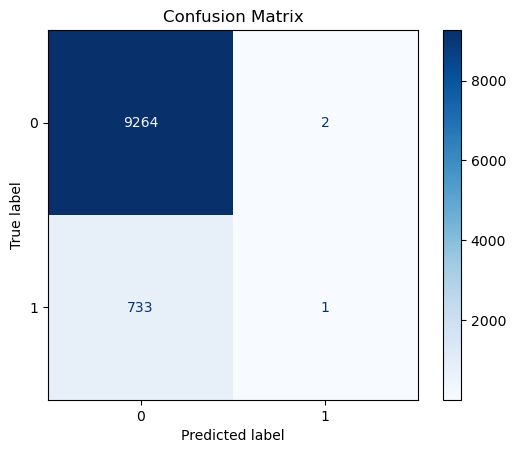

In [ ]:
model = RandomForestClassifier(random_state=9)
roc_auc, roc_auc_cv_mean, cm = evaluate_model(model, X_train, y_train, X_test, y_test)

#### Improving Model

The baseline model is overfitting badly.lets try improving baseline by choosing better hyperparameters that adds bias like
- limiting the max depth 
- limiting the minimum samples required to split the internal and leaf node.
- class_weight='balanced' (adjusts the weights inversely proportional to class frequencies to handle class imbalance)

model ROC-AUC score on test set: 0.7227717458747253
              precision    recall  f1-score   support

           0       0.96      0.69      0.80      9266
           1       0.14      0.63      0.23       734

    accuracy                           0.69     10000
   macro avg       0.55      0.66      0.52     10000
weighted avg       0.90      0.69      0.76     10000

Cross-validated ROC-AUC scores: [0.73829422 0.74753879 0.75387311 0.73401195 0.71276951 0.72119765
 0.74910423 0.71811477 0.76511063 0.70660741]
Mean Cross-validated ROC-AUC score: 0.7346622270956845


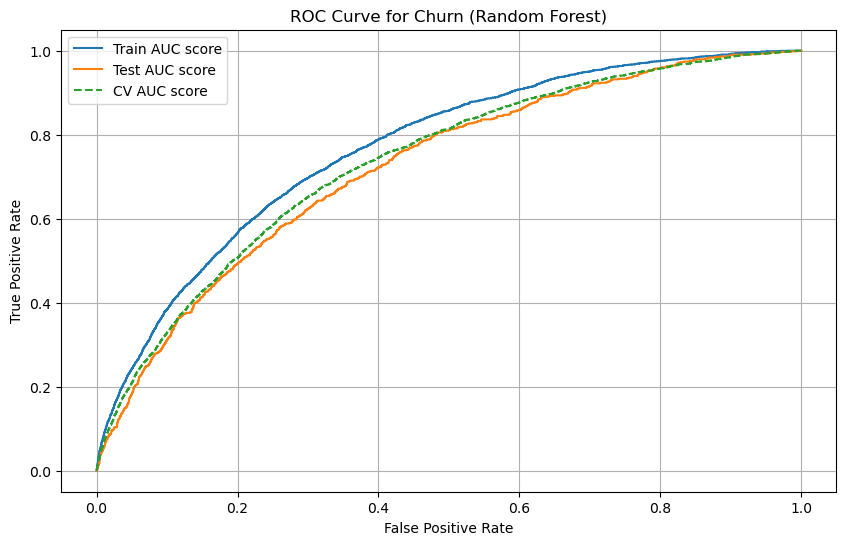

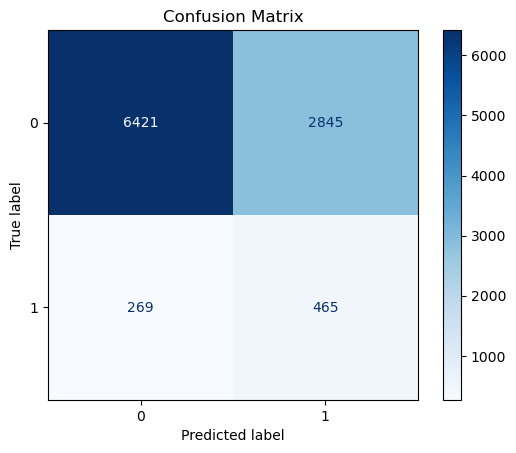

In [ ]:
model = RandomForestClassifier(random_state=9, class_weight='balanced', max_depth=5, min_samples_split=10, min_samples_leaf=5)
roc_auc, roc_auc_cv_mean, cm = evaluate_model(model, X_train, y_train, X_test, y_test)

lets also try an xgboost model

model ROC-AUC score on test set: 0.7037694868762244
              precision    recall  f1-score   support

           0       0.93      0.99      0.96      9266
           1       0.38      0.04      0.07       734

    accuracy                           0.92     10000
   macro avg       0.65      0.52      0.52     10000
weighted avg       0.89      0.92      0.90     10000

Cross-validated ROC-AUC scores: [0.72268313 0.73972219 0.74093766 0.72293505 0.7070553  0.71139098
 0.72480827 0.6972165  0.75568943 0.69593067]
Mean Cross-validated ROC-AUC score: 0.7218369172765333


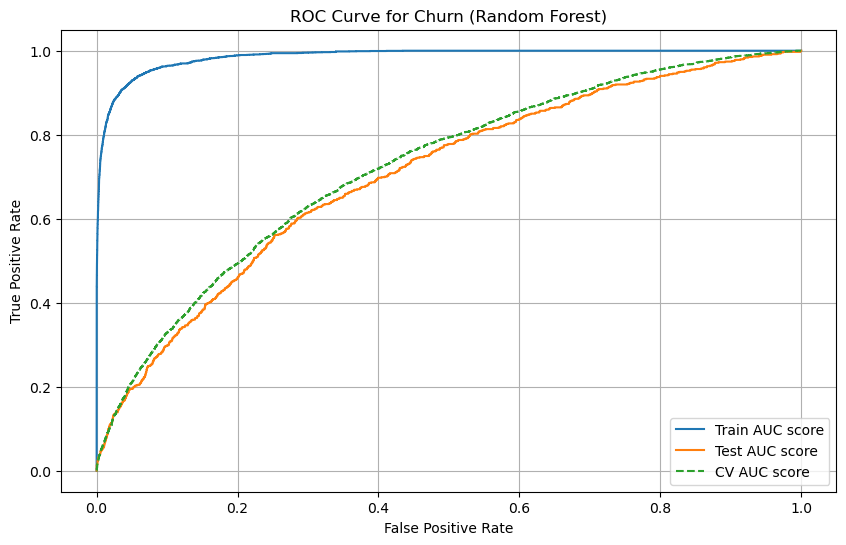

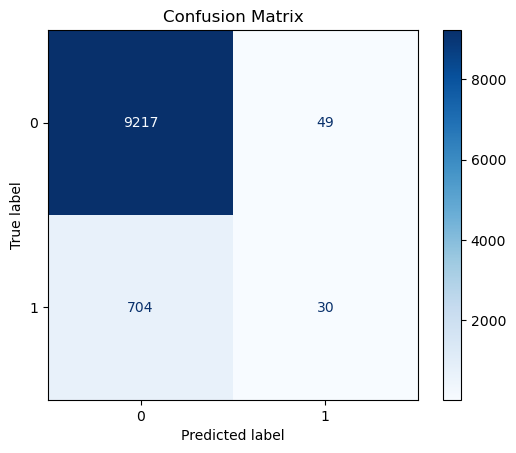

In [ ]:
model = xgb.XGBClassifier(random_state=9)
roc_auc, roc_auc_cv_mean, cm = evaluate_model(model, X_train, y_train, X_test, y_test)

xgboost classifier also seems to overfit

choosing better hyperparameters
- scale_pos_weight: balancing class imbalance
- limiting max depth to prevent overfitting
- increasing min_child_weight, gamma to add regularization
- using subset of features and sample to build trees
- using a lower learning rate and reducing n_estimators as it is overfitting


model ROC-AUC score on test set: 0.7286365553125281
              precision    recall  f1-score   support

           0       0.96      0.69      0.81      9266
           1       0.14      0.65      0.24       734

    accuracy                           0.69     10000
   macro avg       0.55      0.67      0.52     10000
weighted avg       0.90      0.69      0.76     10000

Cross-validated ROC-AUC scores: [0.74936358 0.77316874 0.77386367 0.74189492 0.73682409 0.7312402
 0.77373426 0.72245504 0.77793227 0.71209401]
Mean Cross-validated ROC-AUC score: 0.7492570792355646


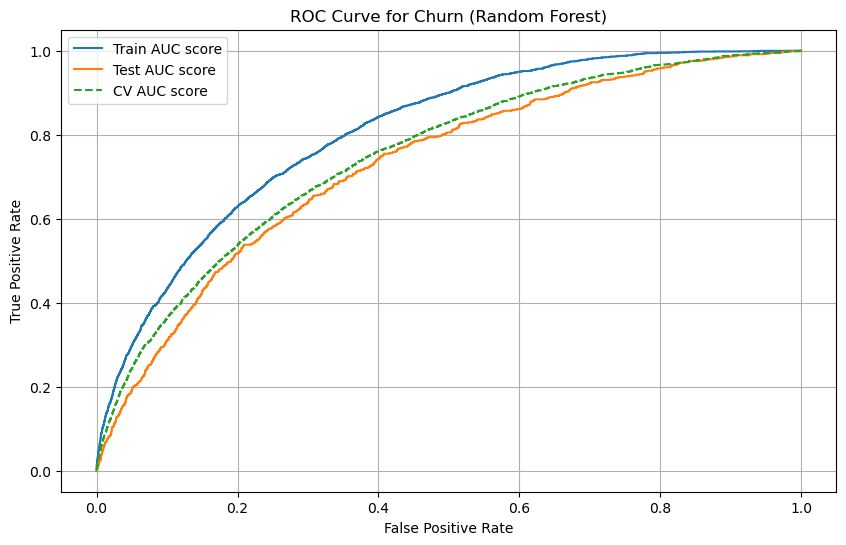

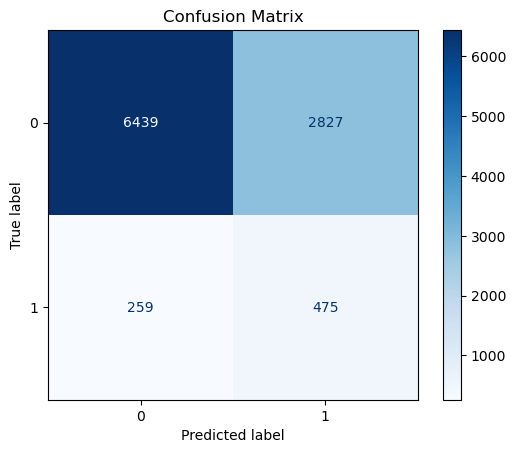

In [ ]:
model = xgb.XGBClassifier(random_state=9, scale_pos_weight= np.sum(y_train == 0) / np.sum(y_train == 1), max_depth=5, min_child_weight=5, 
                          gamma=1, subsample=0.6, colsample_bytree=0.6, learning_rate=0.05, n_estimators=50)
roc_auc, roc_auc_cv_mean, cm = evaluate_model(model, X_train, y_train, X_test, y_test)

#### Feature Selection

In general xgboost performs better in overall metrics, lets continue with this same model an use it for reducing the number of feature.

- For Feature Selection there are various ways(ranking filter methods,correlation methods, domain expertise, elimination methods.etc) 
- As we know from the metrics that the model is not overfitting performing well, we can use to select the relevant features 

In [ ]:
model = xgb.XGBClassifier(random_state=9, scale_pos_weight= np.sum(y_train == 0) / np.sum(y_train == 1), max_depth=5, min_child_weight=5, 
                          gamma=1, subsample=0.6, colsample_bytree=0.6, learning_rate=0.05, n_estimators=50)
model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.6, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=1, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=5, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=50, n_jobs=None,
              num_parallel_tree=None, random_state=9, ...)

In [ ]:
# Feature selection
selector = SelectFromModel(model, threshold="median", prefit=True)
X_train_selected = X_train[X_train.columns[selector.get_support()]]
X_test_selected  = X_test[X_test.columns[selector.get_support()]]

model ROC-AUC score on test set: 0.7288582794559348
              precision    recall  f1-score   support

           0       0.96      0.70      0.81      9266
           1       0.15      0.65      0.24       734

    accuracy                           0.70     10000
   macro avg       0.55      0.68      0.52     10000
weighted avg       0.90      0.70      0.77     10000

Cross-validated ROC-AUC scores: [0.75201238 0.77208832 0.76971431 0.7461324  0.74459141 0.73560617
 0.77258151 0.73156602 0.78116935 0.71605569]
Mean Cross-validated ROC-AUC score: 0.7521517557198079


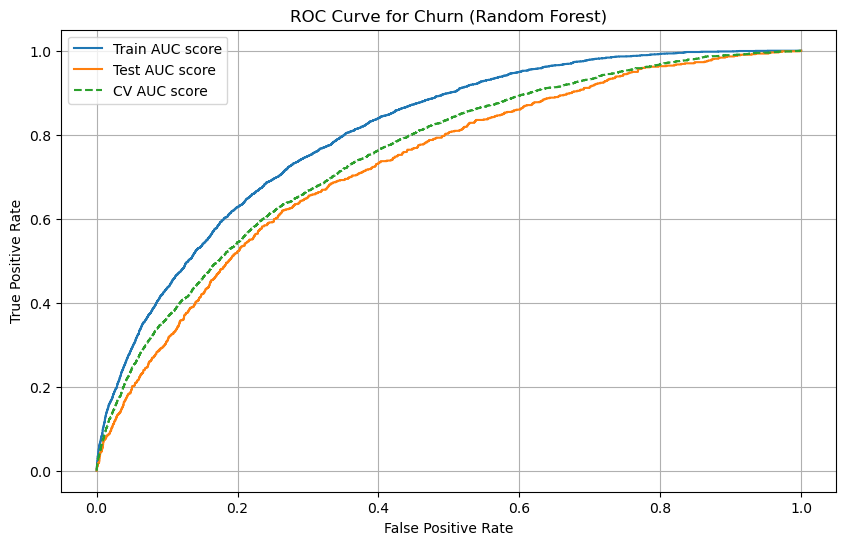

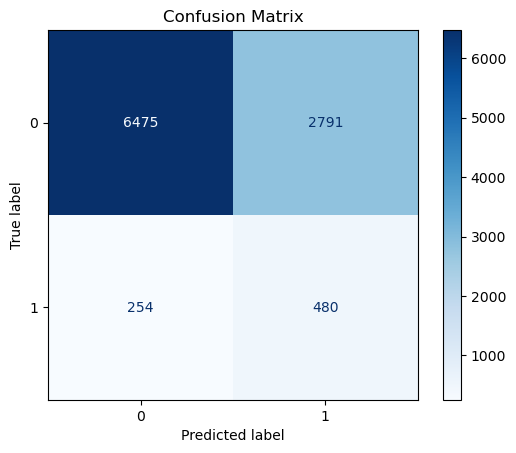

In [ ]:
roc_auc, roc_auc_cv_mean, cm = evaluate_model(model, X_train_selected, y_train, X_test_selected, y_test)

- It performs relatively same and requires on 51 features, therfore lets continue with it.

#### Hyperparameter Tuning

- in general we have a good idea from manual tuning in which the hyperparameters seem to improve the performance.we can use combinations of random and bayesian search to come up with better parameters but for simplicity let's use a grid search.

In [ ]:
param_grid = {
    'max_depth': [3, 5, 7],
    'min_child_weight': [1, 5, 10],
    'gamma': [0, 1, 5],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [20, 30, 50]
}

In [ ]:
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=9)

# Perform grid search
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, scoring='roc_auc', n_jobs=-1, cv=cv, verbose=2)
grid_search.fit(X_train_selected, y_train)

# Best parameters and model
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

Fitting 10 folds for each of 2187 candidates, totalling 21870 fits
[CV] END colsample_bytree=0.6, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=20, subsample=0.6; total time=   0.2s
[CV] END colsample_bytree=0.6, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=20, subsample=0.8; total time=   0.2s
[CV] END colsample_bytree=0.6, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=20, subsample=1.0; total time=   0.2s
[CV] END colsample_bytree=0.6, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=30, subsample=0.6; total time=   0.2s
[CV] END colsample_bytree=0.6, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=30, subsample=0.8; total time=   0.2s
[CV] END colsample_bytree=0.6, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=30, subsample=1.0; total time=   0.2s
[CV] END colsample_bytree=0.6, gamma=0, learning_rate=0.01, max_depth

In [ ]:
print("Best parameters found: ", best_params)

Best parameters found: {'colsample_bytree': 0.6, 'gamma': 1, 'learning_rate': 0.1, 'min_child_weight': 10, 'n_estimators': 50, 'subsample': 0.6} 


model ROC-AUC score on test set: 0.7293539975922052
              precision    recall  f1-score   support

           0       0.96      0.70      0.81      9266
           1       0.15      0.65      0.24       734

    accuracy                           0.70     10000
   macro avg       0.55      0.68      0.53     10000
weighted avg       0.90      0.70      0.77     10000

Cross-validated ROC-AUC scores: [0.75305367 0.77107511 0.77418857 0.75023129 0.74007722 0.74142042
 0.76963721 0.73304735 0.78220279 0.72594726]
Mean Cross-validated ROC-AUC score: 0.75408808950468


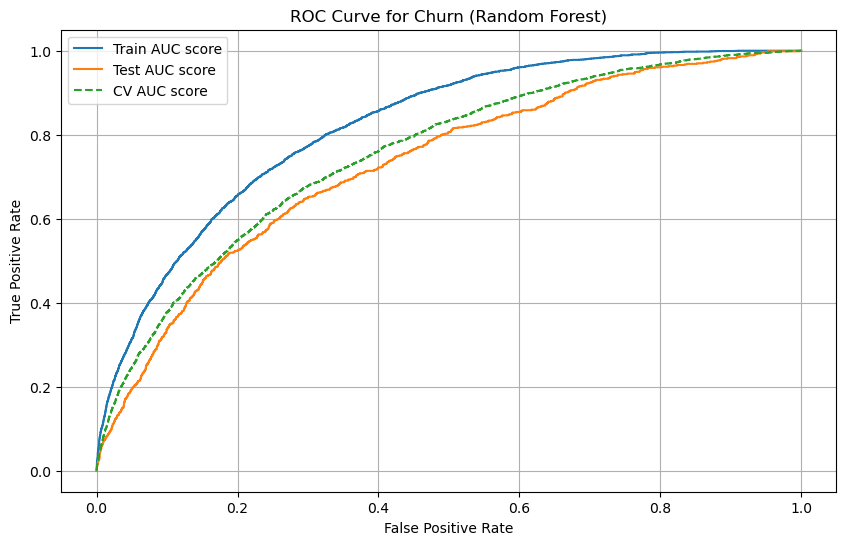

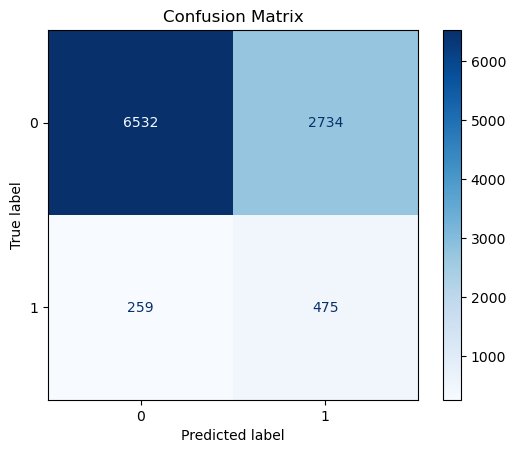

In [ ]:
roc_auc, roc_auc_cv_mean, cm = evaluate_model(best_model, X_train_selected, y_train, X_test_selected, y_test)

- this models seems to perform the best amongst all, we can continue with this

### Deploying the final model

- Training model onn complete data and deploying

In [ ]:
# Combine training and test sets for final training
X_full = pd.concat([X_train_selected, X_test_selected])
y_full = np.concatenate([y_train, y_test])

In [ ]:
final_model = xgb.XGBClassifier(random_state=9, scale_pos_weight= np.sum(y_train == 0) / np.sum(y_train == 1), max_depth=5, min_child_weight=10, 
                          gamma=1, subsample=0.6, colsample_bytree=0.6, learning_rate=0.1, n_estimators=50)

In [ ]:
final_model.fit(X_full, y_full)

#### Save the trained model, encoders, imputers, and mappings

- for mantaing consistency we have to store our encodings,and mappings soit can be applied to the new data set.

In [ ]:
joblib.dump(final_model, '../models/final_xgb_model.pkl')
joblib.dump(selector, '../models/metadata/feature_selector.pkl')
joblib.dump(woe_encoder, '../models/metadata/woe_encoder.pkl')
joblib.dump(ordinal_encoder, '../models/metadata/ordinal_encoder.pkl')
joblib.dump(imp, '../models/metadata/imputer.pkl')
joblib.dump(category_mappings, '../models/metadata/category_mappings.pkl')
joblib.dump(ohe_mapping, '../models/metadata/ohe_mapping.pkl')
joblib.dump(na_flags, '../models/metadata/na_flags.pkl')

print("Final model, feature selector, WOE encoder, ordinal encoder, imputer, category mappings, and OHE mappings saved successfully!")

## Model Limitations and Further Explorations


- The model might still be biased towards the majority class despite handling techniques. We may need to perform more granular analysis, for example we can look at how models perform for different categories of the categorical variables
- Outliers could be treated with domain knowledge evaluating their impact on business
- Better offline/online metrics can be made
- Missingness may need to be further explored using better statiscal test and may provide better results if we properly figure them out.
- imputations techniques like mice can be further explored to provide more accurate imputations.ie- using knn, instead of default regression, using a different strategy etc.
- Preprocessing steps may require re-evaluation with data distribution changes.
- Ensemble models require complex model agnostic methods to understand and as the data is encrypted therefore getting meaningful inference may be difficult.
- XGBoost can be computationally intensive as data scales.
- Interaction usin ICE-plots, h statistics, shap could also be explored for feature engineering
- Creating new features based on properties mean/stddev of numerical features or based on binning based on other threshold etc can be explored.
- Experiments can be performed with other models.